Overarching description...

In [340]:
import pickle

import sys
sys.path.append('../..')

In [341]:
import csv
import pickle
import sys
sys.path.append('../..')

from scipy.interpolate import interp1d

In [342]:
import darkhistory.physics as phys
from config import load_data
import main

import darkhistory.electrons.elec_cooling as elec_cooling
from   darkhistory.spec.spectools import EnglossRebinData
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf

from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.spec.spectools as spectools
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.utilities as utils

import darkhistory.low_energy.atomic as atomic

import darkhistory.history.tla as tla

In [343]:
reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late','FlexKnot_early_1sig', 'FlexKnot_late_1sig', 'Tanh_early', 'Tanh_late', 'Tanh_early_1sig', 'Tanh_late_1sig']
)

input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/'

def make_reion_interp_func(string, He_bump=False):
    Planck_data = []
    with open(input_dir+'/reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)

    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]
        
        #I WebPlot Digitized poorly, so I re-zero
        if string == 'FlexKnot_late':
            Planck_data[26:,1] = 0
        elif string == 'Tanh_late':
            Planck_data[63:,1] = 0
            
        
    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac

    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]

    fac = 2
    if He_bump == False:
        Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
        fac = 1

    return interp1d(Planck_data[:,0], Planck_data[:,1], 
                    bounds_error=False, fill_value=(1+fac*phys.chi,0), kind='linear')

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
bump_interp = make_reion_interp_func('Tanh_late', True)

In [344]:
def plot_distortion(
    ax, run, run2=None,
    xlim=[4e-1, 1e6], ylim=[6e-30, 2e-26],
    label=None, color=None, title=None, alpha=1.0, leg=False,
    first=True, diff=False, rs_lim=None
):
    
    eng = run['distortion'].eng
    hplanck = phys.hbar * 2*np.pi
    nu = eng/hplanck
    convert = phys.nB * eng * hplanck * phys.c / (4*np.pi) * phys.ele * 1e4
    
    ax.loglog()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if rs_lim is not None:
        dist_copy = run['distortions'].copy()
        dist_copy.redshift(rs_lim)
        distortion = dist_copy.sum_specs(run['rs'] >= rs_lim)
    else:
        distortion = run['distortion']
    
    if first:
        ax.plot(nu/1e9, np.ones_like(nu), color='k', 
            linestyle='solid', label='Positive Distortion')
        ax.plot(nu/1e9, np.ones_like(nu), color='k', 
            linestyle='--', label='Negative Distortion')
    
    if not diff:
        ax.plot(nu/1e9, convert * distortion.dNdE,
            color=color, linewidth=1.4,
            label=label, linestyle='solid', alpha=alpha)

        ax.plot(nu/1e9, -convert * distortion.dNdE,
            color=ax.get_lines()[-1].get_color(), linewidth=1.4,
            linestyle='--', alpha=alpha)
        
    else:
        ax.plot(nu/1e9, convert * (distortion.dNdE - run2['distortion'].dNdE),
            color=color, linewidth=1.4,
            label=label, linestyle='solid', alpha=alpha)

        ax.plot(nu/1e9, -convert * (distortion.dNdE - run2['distortion'].dNdE),
            color=ax.get_lines()[-1].get_color(), linewidth=1.4,
            linestyle='--', alpha=alpha)
    
#     ax.set_xticks([1e1,1e2,1e3,1e4,1e5,1e6])
    
    ax.set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
    ax.set_ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    ax.set_title(title, fontsize=16)
    
    if leg:
        ax.legend()
        # leg = axarr[0].legend(fontsize=12, loc=1)
        # leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
        # axarr[0].setp(leg.get_title(),fontsize='12')

In [345]:
fig_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/Drafts/figs/'
savefig=False

# 1. $f_c(z)$ Old vs. New

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [9]:
pri = 'elec'
DM_process = 'swave'

log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

if pri=='elec':
    if DM_process=='decay':
        mDM_list = 2*(10**log10eng + phys.me)
        
    else:
        mDM_list = 10**log10eng + phys.me

elif pri=='phot':
    if DM_process=='decay':
        mDM_list = 2*10**log10eng
    else:
        mDM_list = 10**log10eng

fs_data = pickle.load(open(
    '/Users/gregoryridgway/Desktop/Data'+
    '/data_fs_'+pri+'_'+DM_process+'.dat', 'rb'))

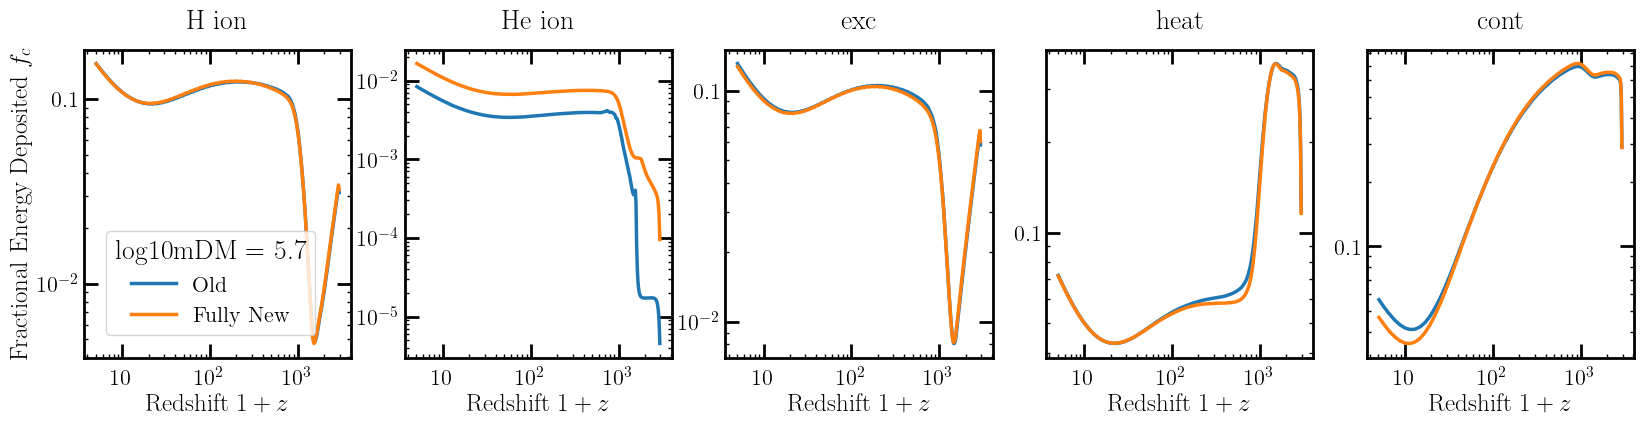

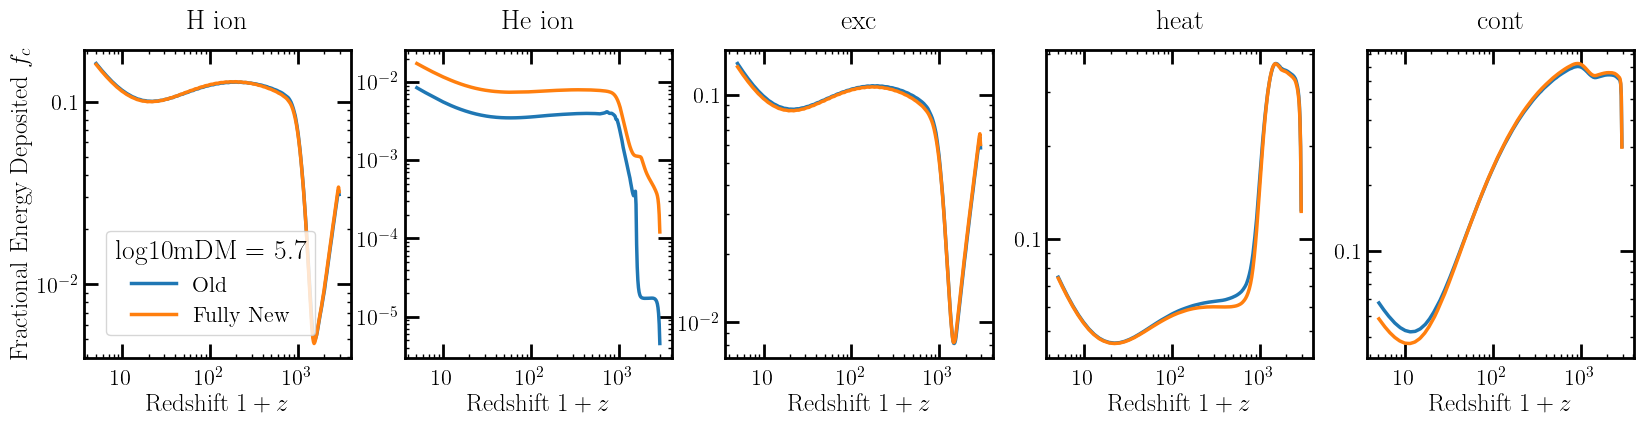

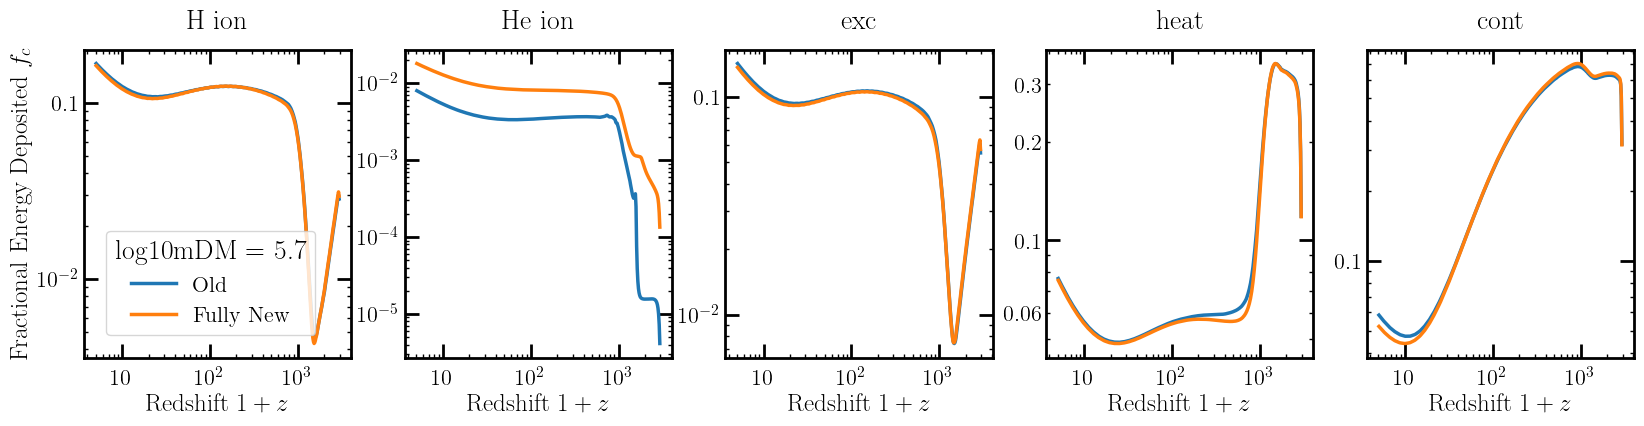

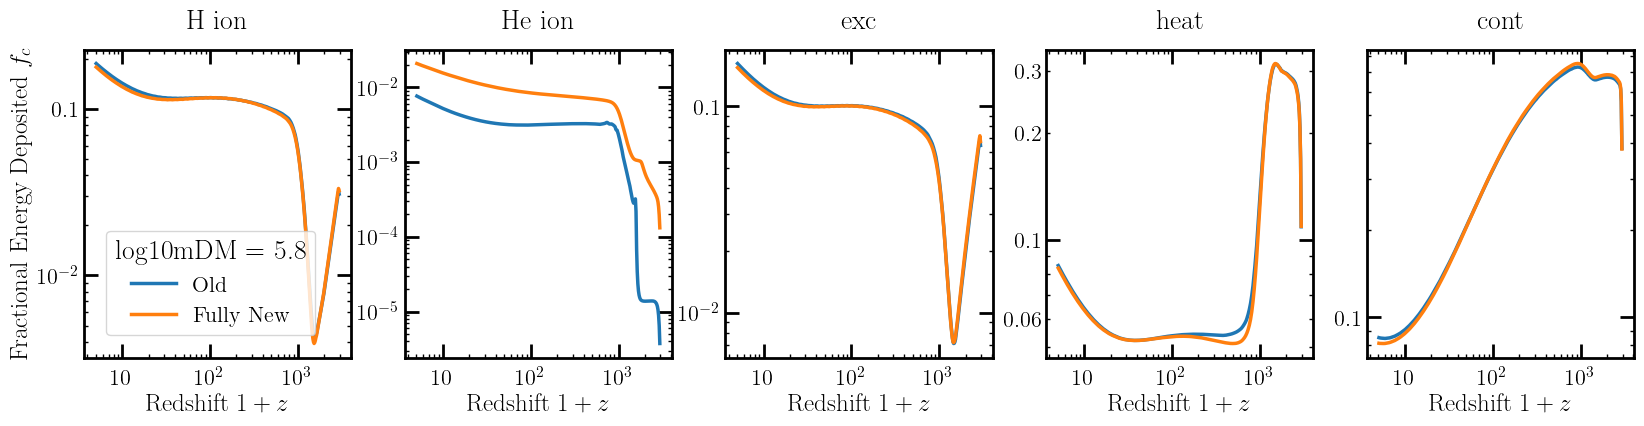

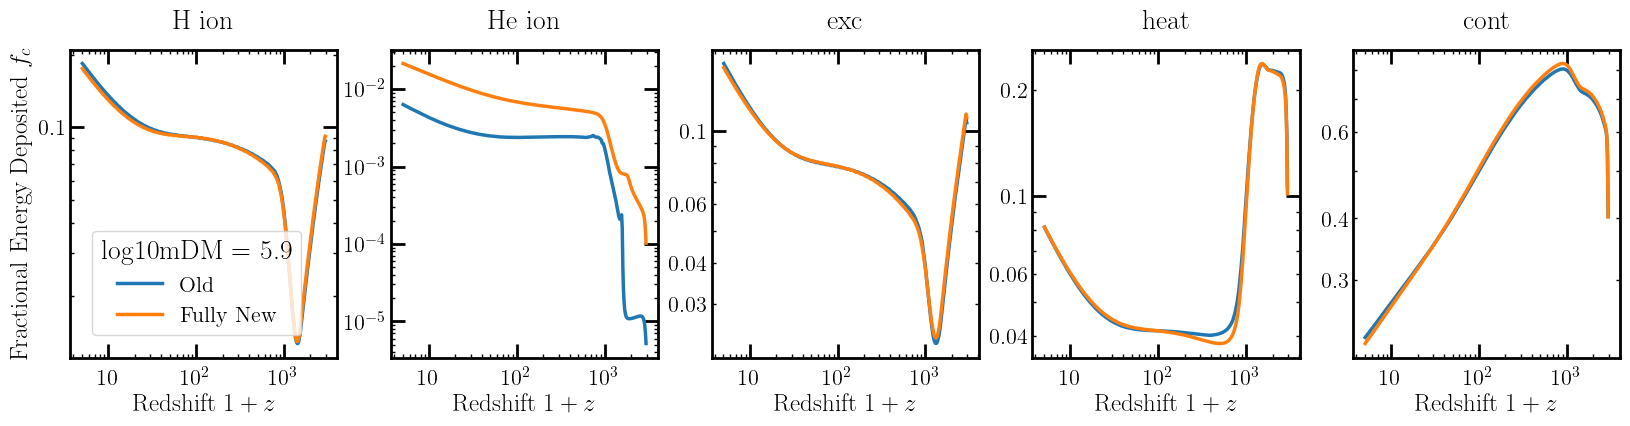

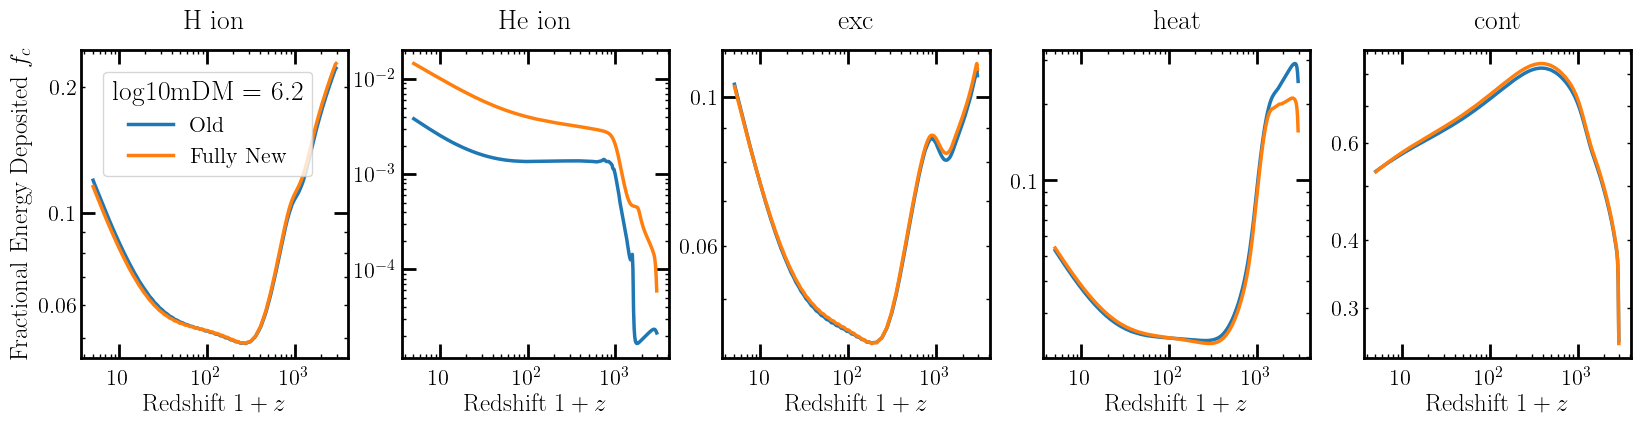

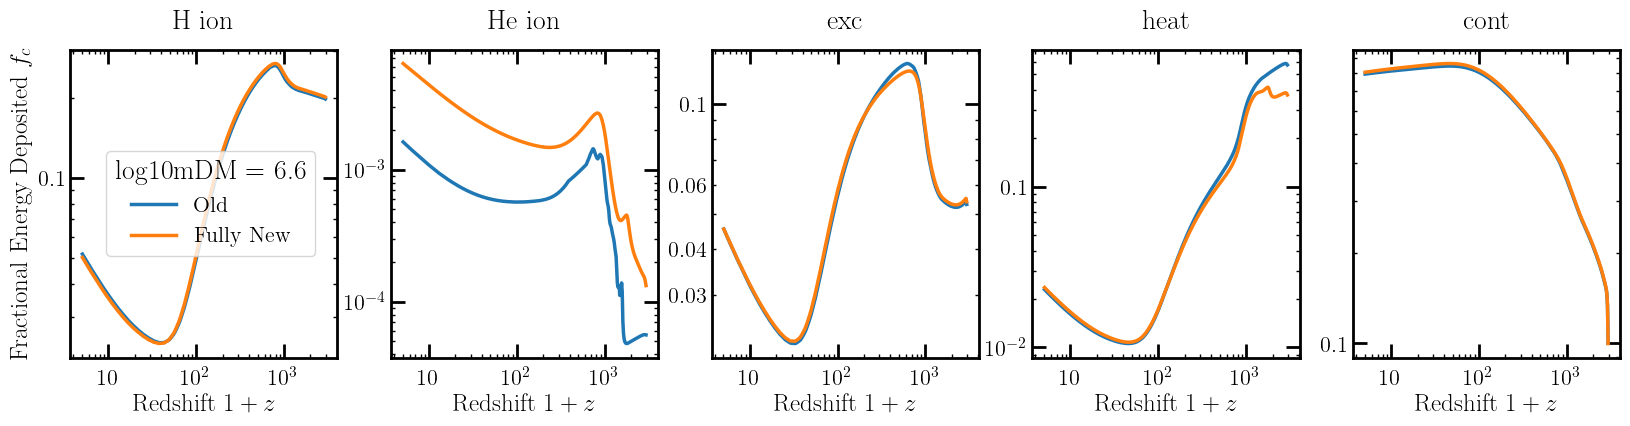

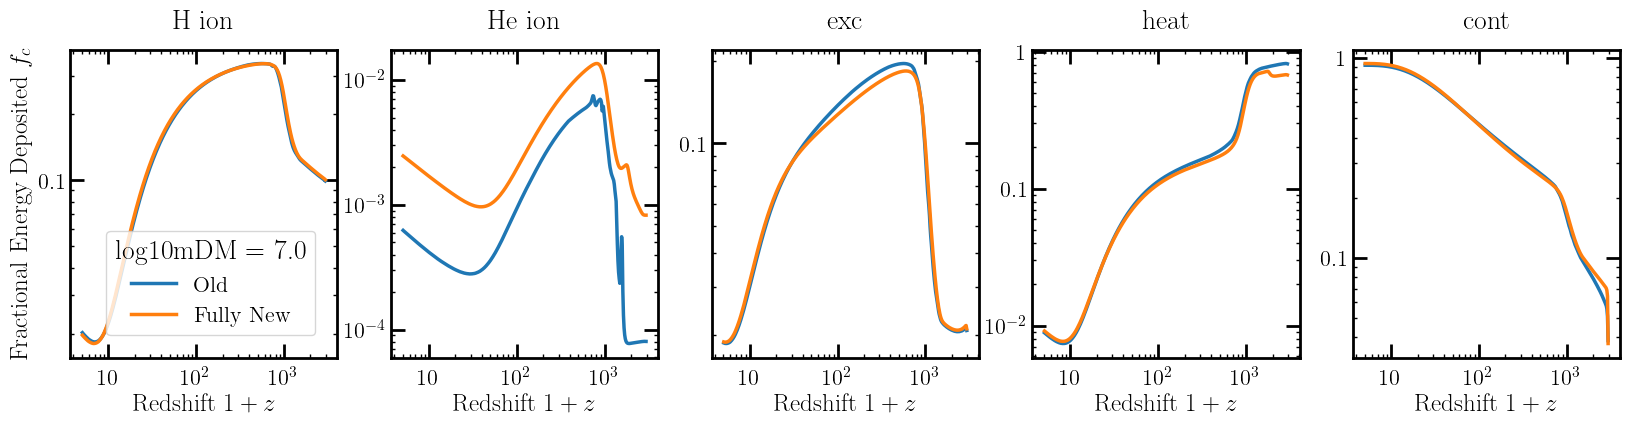

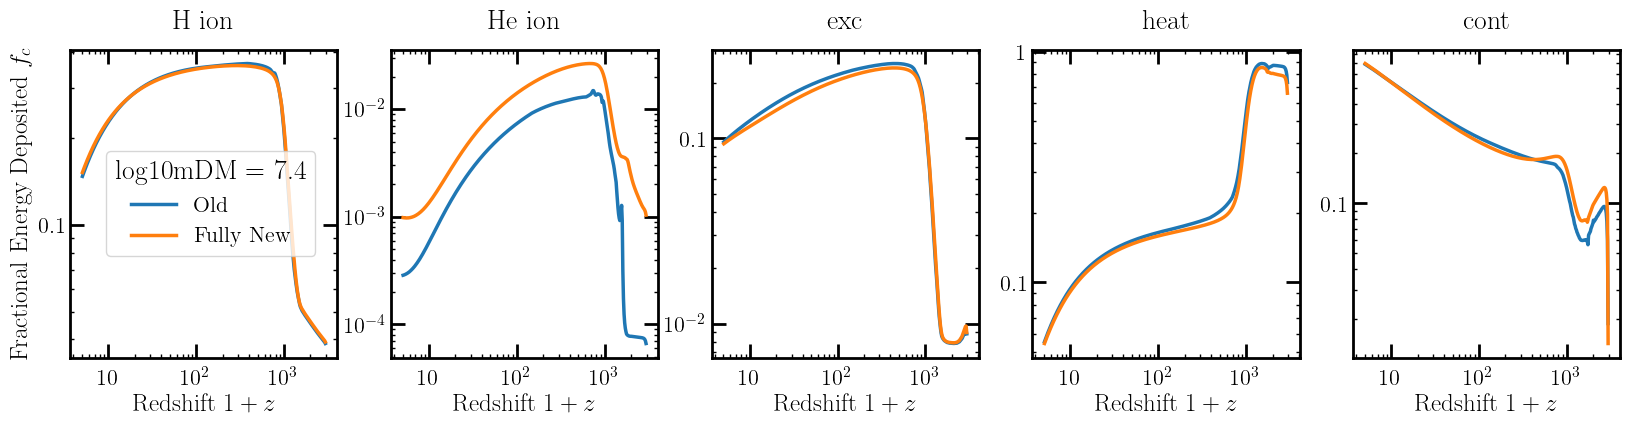

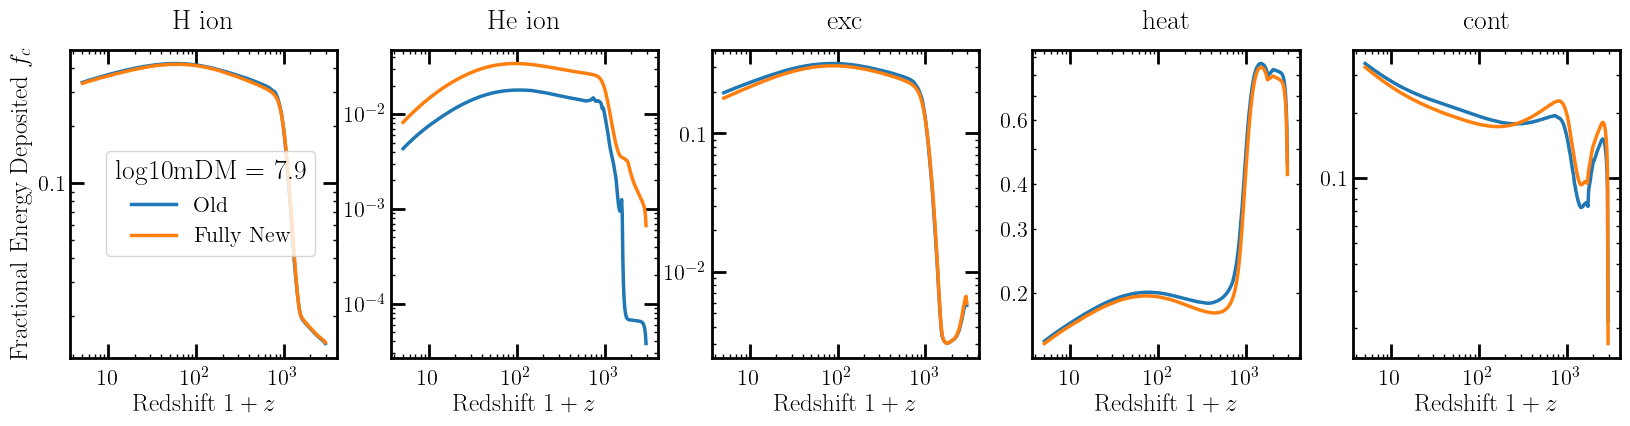

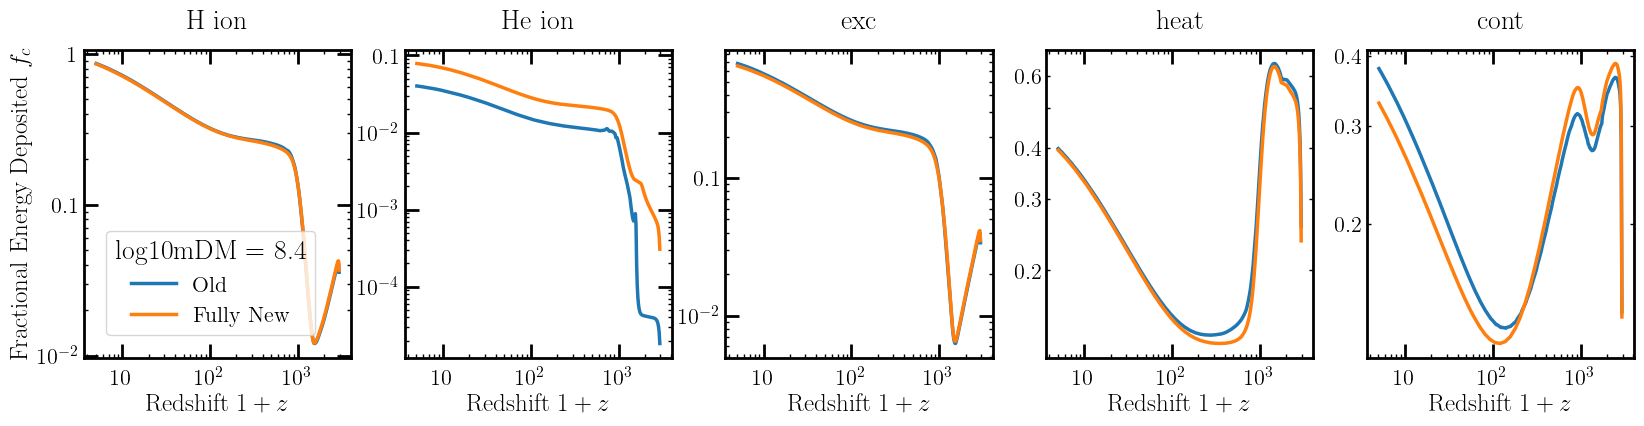

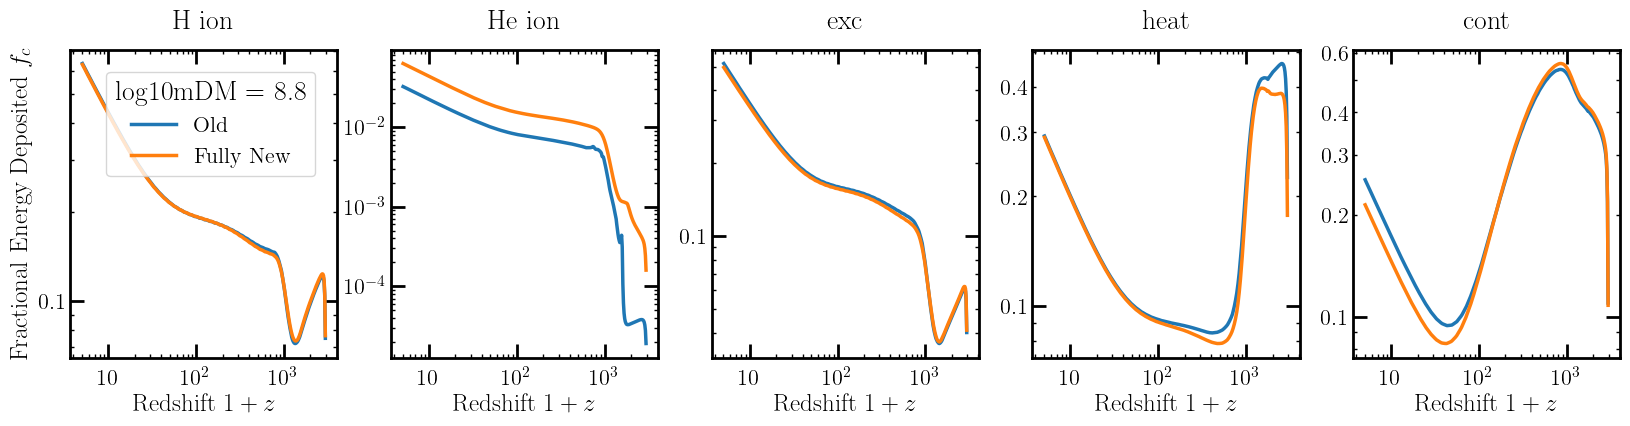

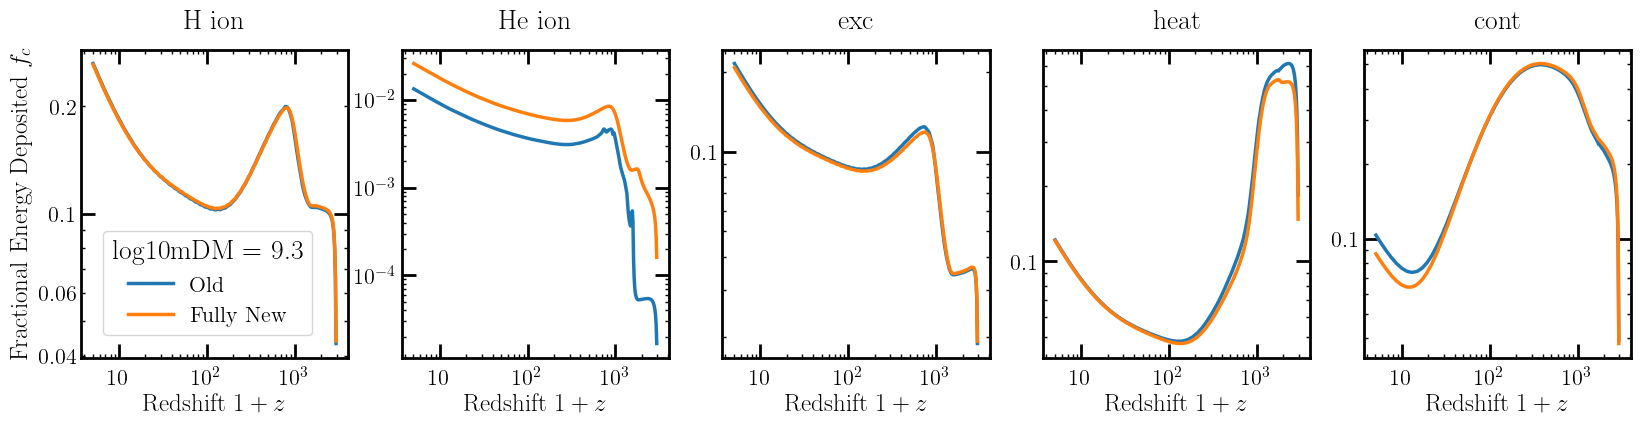

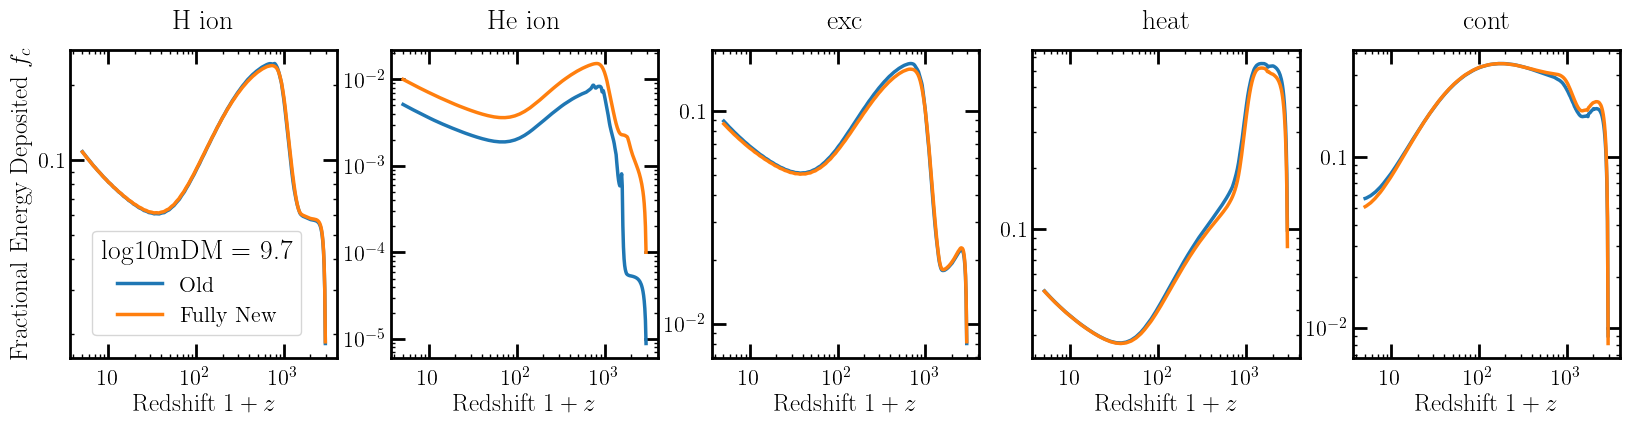

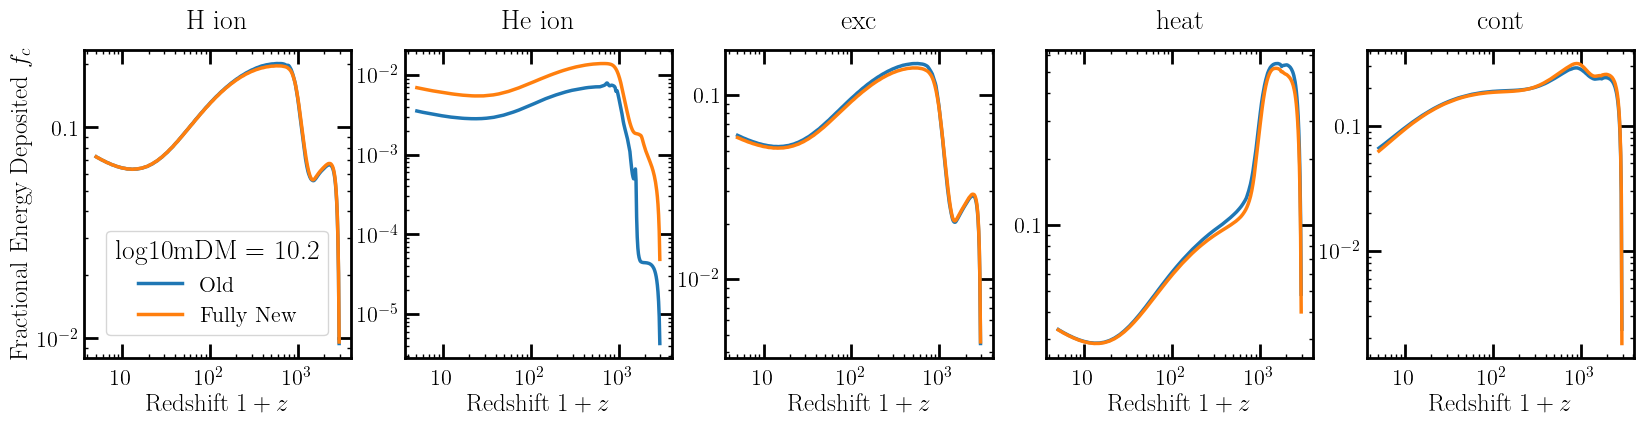

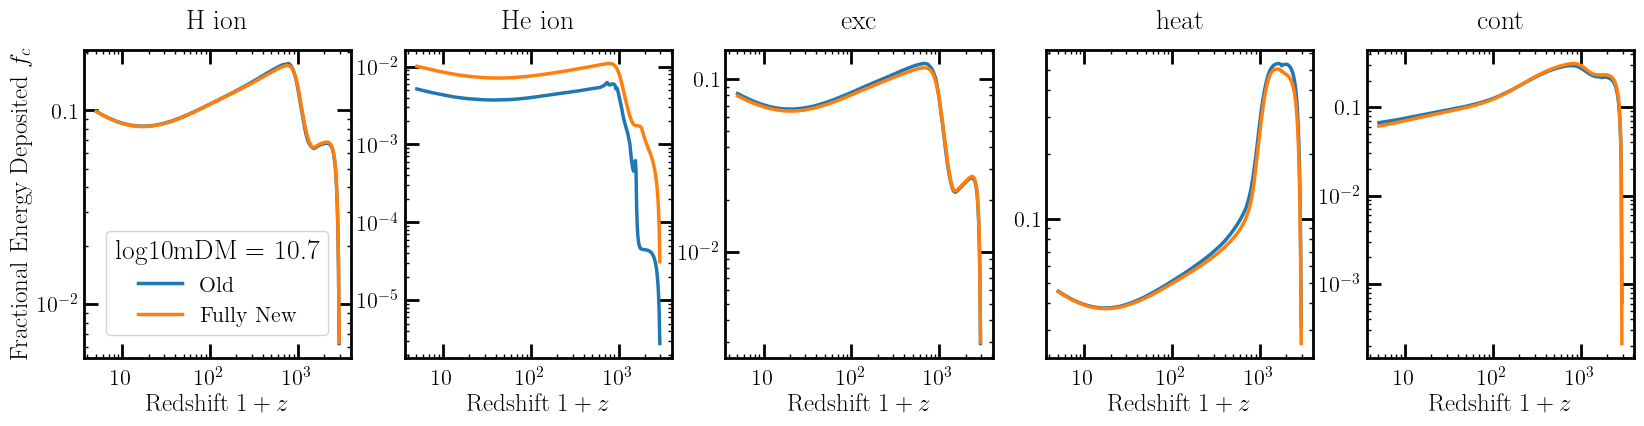

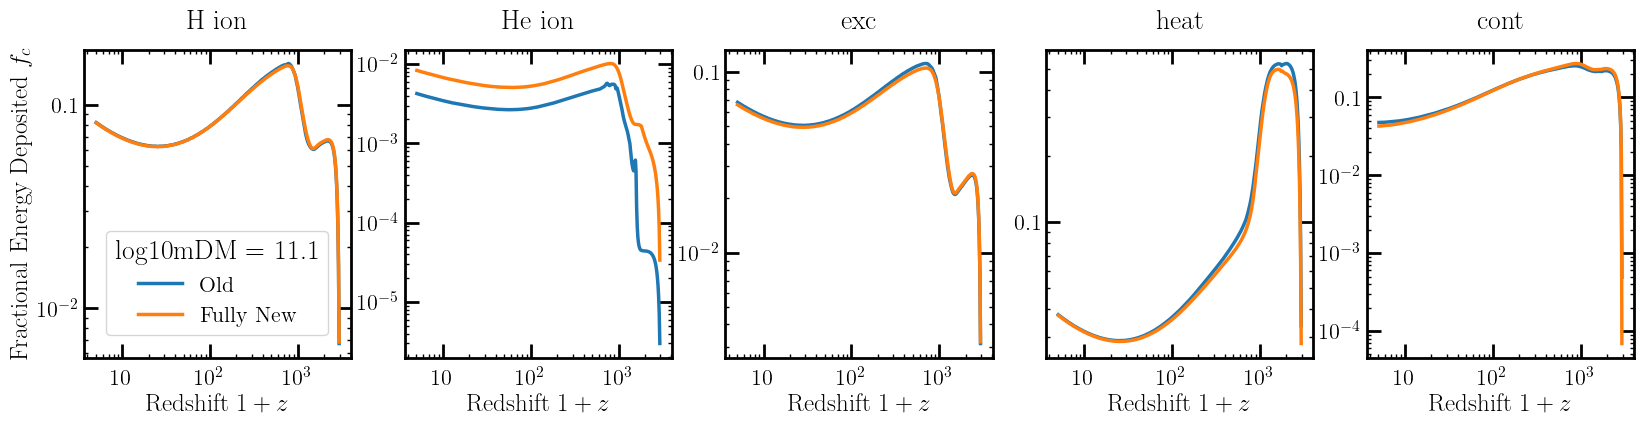

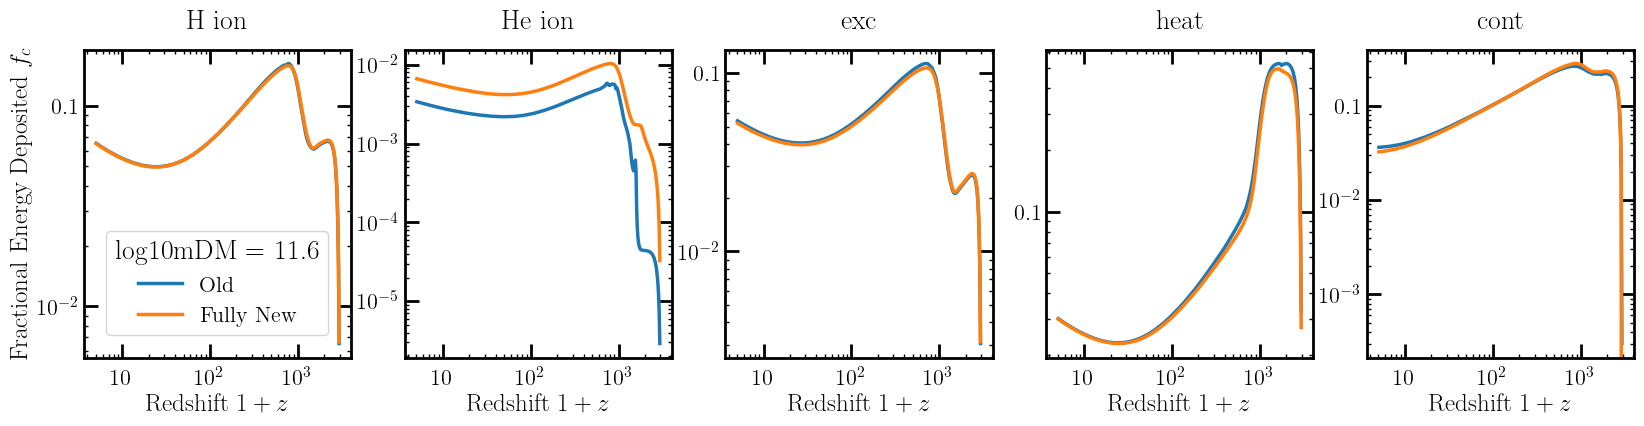

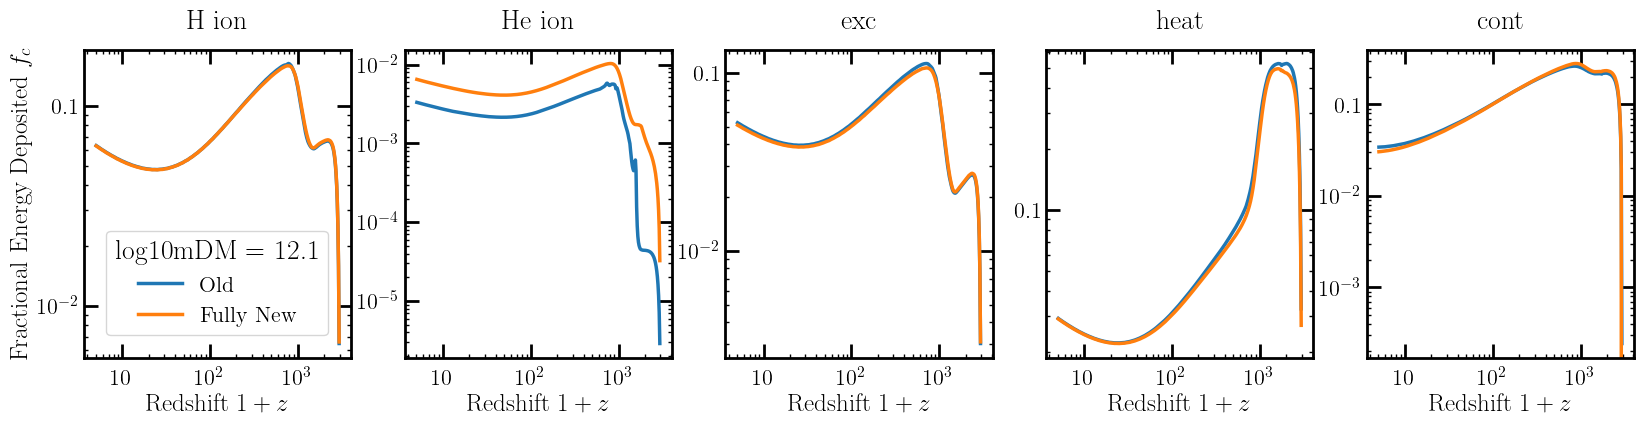

In [10]:
rs_tmp = np.exp(np.arange(np.log(3e3), np.log(5), -.001*16))
for m_ind in np.arange(0,38,2):

    mDM = mDM_list[m_ind]

    fig, axarr = plt.subplots(1,5, figsize=(4*5,4))

    ch_std = ['H ion', 'He ion', 'exc', 'heat', 'cont']
    ch_run = ['H ion', 'He ion', 'Lya', 'heat', 'cont']

    for i in np.arange(5):
        axarr[i].loglog()
        axarr[i].set_xlabel(r'Redshift $1+z$')
        axarr[i].set_title(ch_std[i], fontsize=20)

        axarr[i].plot(
            rs_tmp[1:], phys.f_std(mDM, rs_tmp[1:], pri, DM_process, channel=ch_std[i]), label='Old'
        )

        axarr[i].plot(rs_tmp[1:], fs_data[m_ind][ch_run[i]][1:], label='Fully New')

    axarr[0].set_ylabel(r'Fractional Energy Deposited $f_c$')
    axarr[0].legend(title='log10mDM = '+"{:.1f}".format(np.log10(mDM)))

In [228]:
def get_fdiff(pri, DM_process, channel, ax, notFirst=True):
    
    ind = {'H ion' : 0, 'He ion' : 1, 'Lya' : 2, 'heat' : 3, 'cont' : 4}[channel]
    ch_std = ['H ion', 'He ion', 'exc', 'heat', 'cont']
    ch_run = ['H ion', 'He ion', 'Lya', 'heat', 'cont']
    
    rs_tmp = np.exp(np.arange(np.log(3e3), np.log(5), -.001*16))
    eng = 10**log10eng
    
    f_NEW = np.ones((eng.size, rs_tmp.size-2))*1e-6
    f_OLD = np.ones((eng.size, rs_tmp.size-2))*1e-6
    
    for m_ind in np.arange(eng.size-1):
        f_NEW[m_ind] = fs_data[m_ind][ch_run[ind]][2:]
        f_OLD[m_ind] = phys.f_std(mDM_list[m_ind], rs_tmp[2:], 
                              pri, DM_process, channel=ch_std[ind])
        
        if m_ind == 0:
            print(sum(f_OLD[m_ind]))
        
#             print(max(f_OLD[m_ind]/f_NEW[m_ind]-1))
    
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]
        
    else:
        label = channel
        
    title = r'\bf{$f_{'+label+'}$}'

    ax.loglog()
    
    levels=[0,.01,.05,.1,.2,.5,1.]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_NEW)
    diffs = np.abs(
        f_NEW - f_OLD
    )/f_NEW
    
    cs = ax.contourf(eng, rs_tmp[2:], np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r)
    
    if channel == 'cont':
        cbar = plt.colorbar(cs, ticks=levels)
    
    ax.set_title(title)
    if not notFirst:
        ax.set_ylabel(r'Redshift ($1+z$)')
    ax.set_xlabel(r'Kinetic Energy [eV]')

38.29185658674304
1.4328534714854684
33.096101127702845
39.78967676346295
129.36679327010722


<Figure size 620x620 with 0 Axes>

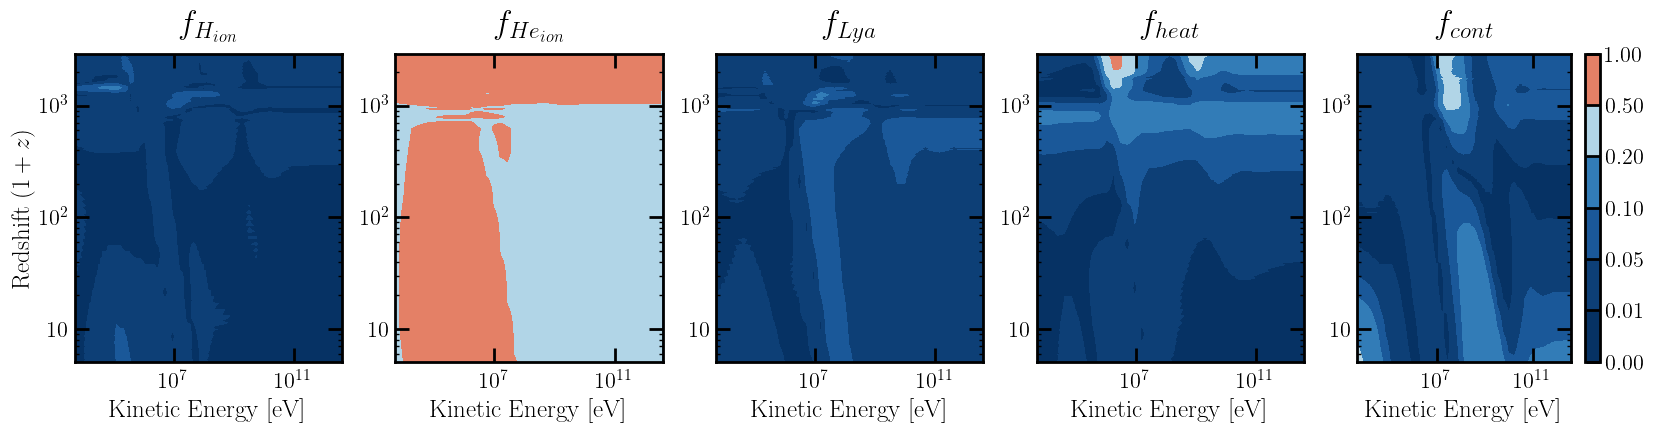

In [231]:
plt.figure()
f, axarr = plt.subplots(1,5, figsize = (20, 20/5.), sharex=True)
ax = plt.gca()

for i, chan in enumerate(['H ion', 'He ion', 'Lya', 'heat', 'cont']):
    get_fdiff(pri, DM_process, chan, axarr[i], notFirst=bool(i))
    
# f.tight_layout()
if savefig:
    plt.savefig(fig_dir+'f_heatmap_crosscheck.pdf')

# 2. $f_c(z)$ vs. MEDEA

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [388]:
# Load data.
binning = load_data('binning')
photeng = binning['phot']
eleceng = binning['elec']

dep_tf_data = load_data('dep_tf')

ics_tf_data = load_data('ics_tf')

ics_thomson_ref_tf  = ics_tf_data['thomson']
ics_rel_ref_tf      = ics_tf_data['rel']
engloss_ref_tf      = ics_tf_data['engloss']

#MEDEA
H_states = ['2s', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p']

(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs,
    ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

In [389]:
%autoreload
#Probs that a given state decays ultimately to '2p'
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

#ionization levels probed by MEDEA
xes = np.array([
    1e-4, 1.5e-4, 2e-4, 3e-4, 5e-4,
    1e-3, 1.5e-3, 2e-3, 3e-3, 5e-3,
    1e-2, 1.5e-2, 2e-2, 3e-2, 5e-2,
    1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1,
    7e-1, 8e-1, 9e-1, 9.5e-1, 9.9e-1, 
    1.0
])

channels = ['heat', 'exc', 'H ion', 'He ion', 'cont']
fs = {chan: np.zeros((xes.size, eleceng.size)) for chan in channels}

In [403]:
%autoreload
rs=1
for i,xHII in enumerate(tqdm(xes)):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_arr
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=xHII * phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            H_states=H_states,
            check_conservation_eng=True
        )

    fs['heat'][i]   = deposited_heat_arr/eleceng
    fs['H ion'][i]  = deposited_ion_arr['H']/eleceng
    fs['He ion'][i] = deposited_ion_arr['He']/eleceng
    
    fs['exc'][i]  = np.sum([
        deposited_exc_arr[species]*Ps[species] * phys.lya_eng/phys.H_exc_eng(species)
    for species in Ps], axis=0)/eleceng

    fs['cont'][i] = np.sum([
        deposited_exc_arr[species]*(1-Ps[species]) * (1+1-phys.lya_eng/phys.H_exc_eng(species))
    for species in Ps], axis=0)/eleceng + (
    deposited_ICS_arr/eleceng)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_80363/992264771.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,xHII in enumerate(tqdm(xes)):


  0%|          | 0/26 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [393]:
%autoreload
rs=1
for i,xHII in enumerate(tqdm(xes[:1])):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_arr
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=xHII * phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            H_states=H_states,
            check_conservation_eng=True
        )

    fs['heat'][i]   = deposited_heat_arr/eleceng
    fs['H ion'][i]  = deposited_ion_arr['H']/eleceng
    fs['He ion'][i] = deposited_ion_arr['He']/eleceng
    
    fs['exc'][i]  = np.sum([
        deposited_exc_arr[species]*Ps[species] * phys.lya_eng/phys.H_exc_eng(species)
    for species in Ps], axis=0)/eleceng

    fs['cont'][i] = np.sum([
        deposited_exc_arr[species]*(1-Ps[species]) * (1+1-phys.lya_eng/phys.H_exc_eng(species))
    for species in Ps], axis=0)/eleceng + (
    deposited_ICS_arr/eleceng)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_80363/1988879760.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,xHII in enumerate(tqdm(xes[:1])):


  0%|          | 0/1 [00:00<?, ?it/s]

***************************************************
rs:  1
injected energy:  1.029782576544676
Fraction of Energy in photons - Continuum:  -0.9082011044668986
Fraction Deposited in ionization:  0.0
Fraction Deposited in excitation 2s:  0.0
Fraction Deposited in excitation 2p:  0.0
Fraction Deposited in excitation 3p:  0.0
Fraction Deposited in excitation 4p:  0.0
Fraction Deposited in excitation 5p:  0.0
Fraction Deposited in excitation 6p:  0.0
Fraction Deposited in excitation 7p:  0.0
Fraction Deposited in excitation 8p:  0.0
Fraction Deposited in excitation 9p:  0.0
Fraction Deposited in excitation 10p:  0.0
Fraction Deposited in excitation HeI:  0.0
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  1.0
Energy is conserved up to (%):  -0.0004748691558822707
Fraction Deposited in ICS (Numerical Error):  -4.748691558822707e-06
Energy conservation with deposited (%):  0.0
***************************************************
*************************************

Fraction Deposited in excitation 7p:  0.0
Fraction Deposited in excitation 8p:  0.0
Fraction Deposited in excitation 9p:  0.0
Fraction Deposited in excitation 10p:  0.0
Fraction Deposited in excitation HeI:  0.0
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  0.9999999999999998
Energy is conserved up to (%):  -0.005877857116399757
Fraction Deposited in ICS (Numerical Error):  -5.8778571164156904e-05
Energy conservation with deposited (%):  1.5933146531707592e-14
***************************************************
***************************************************
rs:  1
injected energy:  10.774290907022078
Fraction of Energy in photons - Continuum:  -20.1774399129157
Fraction Deposited in ionization:  0.0
Fraction Deposited in excitation 2s:  0.0
Fraction Deposited in excitation 2p:  0.0
Fraction Deposited in excitation 3p:  0.0
Fraction Deposited in excitation 4p:  0.0
Fraction Deposited in excitation 5p:  0.0
Fraction Deposited in excitation 6p:  0.0
Frac

Fraction Deposited in heating:  0.22876279982215575
Energy is conserved up to (%):  -0.001601546266559651
Fraction Deposited in ICS (Numerical Error):  -1.6015462665554423e-05
Energy conservation with deposited (%):  -4.208884569291886e-15
***************************************************
***************************************************
rs:  1
injected energy:  66.46792860905407
Fraction of Energy in photons - Continuum:  -25.091880902363346
Fraction Deposited in ionization:  0.32856738843944766
Fraction Deposited in excitation 2s:  0.03357774682938905
Fraction Deposited in excitation 2p:  0.3118558616021161
Fraction Deposited in excitation 3p:  0.054970186682486884
Fraction Deposited in excitation 4p:  0.01978591074460248
Fraction Deposited in excitation 5p:  0.009511698315972466
Fraction Deposited in excitation 6p:  0.005320101411147982
Fraction Deposited in excitation 7p:  0.00328258249898073
Fraction Deposited in excitation 8p:  0.0021703532552570363
Fraction Deposited in exci

Fraction Deposited in excitation 7p:  0.003385282708556455
Fraction Deposited in excitation 8p:  0.0022404925689733885
Fraction Deposited in excitation 9p:  0.0015564269150582252
Fraction Deposited in excitation 10p:  0.0011224672181978455
Fraction Deposited in excitation HeI:  0.007171134254622316
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  0.16915099821346682
Energy is conserved up to (%):  -0.0032962842302455627
Fraction Deposited in ICS (Numerical Error):  -3.296284230316233e-05
Energy conservation with deposited (%):  7.067070118932129e-14
***************************************************
***************************************************
rs:  1
injected energy:  549.9092016877257
Fraction of Energy in photons - Continuum:  -157.99734226199382
Fraction Deposited in ionization:  0.3963787856015175
Fraction Deposited in excitation 2s:  0.024638578039086364
Fraction Deposited in excitation 2p:  0.30358351215837903
Fraction Deposited in excitation 3p

Fraction Deposited in ionization:  0.39826063949738516
Fraction Deposited in excitation 2s:  0.018233455544260795
Fraction Deposited in excitation 2p:  0.31301743859403625
Fraction Deposited in excitation 3p:  0.05755224706785279
Fraction Deposited in excitation 4p:  0.02098323646565524
Fraction Deposited in excitation 5p:  0.010114954299685059
Fraction Deposited in excitation 6p:  0.005666756057624266
Fraction Deposited in excitation 7p:  0.0035002335177468495
Fraction Deposited in excitation 8p:  0.0023141397257119187
Fraction Deposited in excitation 9p:  0.0016098534225185068
Fraction Deposited in excitation 10p:  0.0011615797982219187
Fraction Deposited in excitation HeI:  0.008968486603454881
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  0.15841219539648055
Energy is conserved up to (%):  0.027863893094429437
Fraction Deposited in ICS (Numerical Error):  0.00027863893094392617
Energy conservation with deposited (%):  3.681928378919038e-14
************

Fraction Deposited in heating:  0.1512380582803233
Energy is conserved up to (%):  0.1631276559255933
Fraction Deposited in ICS (Numerical Error):  0.001631276559255256
Energy conservation with deposited (%):  6.772127124850629e-14
***************************************************
***************************************************
rs:  1
injected energy:  71787.78268721356
Fraction of Energy in photons - Continuum:  -22161.123473670013
Fraction Deposited in ionization:  0.384361902880981
Fraction Deposited in excitation 2s:  0.018151093103488145
Fraction Deposited in excitation 2p:  0.31843820526008443
Fraction Deposited in excitation 3p:  0.05851006439293402
Fraction Deposited in excitation 4p:  0.021317518344492952
Fraction Deposited in excitation 5p:  0.010268894259193119
Fraction Deposited in excitation 6p:  0.005751571566216282
Fraction Deposited in excitation 7p:  0.00355161220080274
Fraction Deposited in excitation 8p:  0.0023464239913041397
Fraction Deposited in excitation 9

Fraction Deposited in excitation 5p:  0.005294675641110501
Fraction Deposited in excitation 6p:  0.0029651006377392855
Fraction Deposited in excitation 7p:  0.0018307858420290675
Fraction Deposited in excitation 8p:  0.0012096431489924146
Fraction Deposited in excitation 9p:  0.0008419201298744388
Fraction Deposited in excitation 10p:  0.0006074453914765473
Fraction Deposited in excitation HeI:  0.005279309691680686
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  0.0756584109252514
Energy is conserved up to (%):  0.3122807002645147
Fraction Deposited in ICS (Numerical Error):  0.003122807002644154
Energy conservation with deposited (%):  9.932043730677794e-14
***************************************************
***************************************************
rs:  1
injected energy:  1201219.3761754245
Fraction of Energy in photons - Continuum:  -266408.7285825173
Fraction Deposited in ionization:  0.1844682279180664
Fraction Deposited in excitation 2s:  0

rs:  1
injected energy:  18954094.407983918
Fraction of Energy in photons - Continuum:  -384657.78643486404
Fraction Deposited in ionization:  0.013846316250092444
Fraction Deposited in excitation 2s:  0.0006358567642816117
Fraction Deposited in excitation 2p:  0.011859330083556843
Fraction Deposited in excitation 3p:  0.002178407904018426
Fraction Deposited in excitation 4p:  0.000793418816733547
Fraction Deposited in excitation 5p:  0.00038207867366839006
Fraction Deposited in excitation 6p:  0.0002139666038477822
Fraction Deposited in excitation 7p:  0.0001321112502475309
Fraction Deposited in excitation 8p:  8.729010249265271e-05
Fraction Deposited in excitation 9p:  6.075342637550044e-05
Fraction Deposited in excitation 10p:  4.3834054500902646e-05
Fraction Deposited in excitation HeI:  0.00038218991288619476
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  0.005454361249771718
Energy is conserved up to (%):  0.035469051030150724
Fraction Deposited in IC

Fraction of Energy in photons - Continuum:  -384974.8824781768
Fraction Deposited in ionization:  0.0009318937047369183
Fraction Deposited in excitation 2s:  4.279321291300893e-05
Fraction Deposited in excitation 2p:  0.0007981971353141746
Fraction Deposited in excitation 3p:  0.00014661859920514505
Fraction Deposited in excitation 4p:  5.340134421386721e-05
Fraction Deposited in excitation 5p:  2.571593557540313e-05
Fraction Deposited in excitation 6p:  1.4401092522776797e-05
Fraction Deposited in excitation 7p:  8.891789999655167e-06
Fraction Deposited in excitation 8p:  5.875089227958965e-06
Fraction Deposited in excitation 9p:  4.089028541275657e-06
Fraction Deposited in excitation 10p:  2.9502652570957605e-06
Fraction Deposited in excitation HeI:  2.572442322538172e-05
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  0.00036719383594111
Energy is conserved up to (%):  0.002479219178614253
Fraction Deposited in ICS (Numerical Error):  2.4792191785533715e-

Fraction Deposited in excitation 3p:  1.6711771326299625e-05
Fraction Deposited in excitation 4p:  6.086751989897237e-06
Fraction Deposited in excitation 5p:  2.931134485675275e-06
Fraction Deposited in excitation 6p:  1.6414545269291482e-06
Fraction Deposited in excitation 7p:  1.0134973378846883e-06
Fraction Deposited in excitation 8p:  6.696500141795645e-07
Fraction Deposited in excitation 9p:  4.6607258372407197e-07
Fraction Deposited in excitation 10p:  3.362749216540337e-07
Fraction Deposited in excitation HeI:  2.932102757634114e-06
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  4.1854015149341765e-05
Energy is conserved up to (%):  0.00028327714634646925
Fraction Deposited in ICS (Numerical Error):  2.83277146247828e-06
Energy conservation with deposited (%):  9.864129450595596e-14
***************************************************
***************************************************
rs:  1
injected energy:  2623938616.17666
Fraction of Energy in ph

Fraction of Energy in photons - Continuum:  -384976.5176571461
Fraction Deposited in ionization:  7.57009201981035e-06
Fraction Deposited in excitation 2s:  3.4762383883787603e-07
Fraction Deposited in excitation 2p:  6.484030955940437e-06
Fraction Deposited in excitation 3p:  1.1910335072799027e-06
Fraction Deposited in excitation 4p:  4.3379755673815386e-07
Fraction Deposited in excitation 5p:  2.0889942294473247e-07
Fraction Deposited in excitation 6p:  1.1698504627914194e-07
Fraction Deposited in excitation 7p:  7.223107983151693e-08
Fraction Deposited in excitation 8p:  4.772537808072325e-08
Fraction Deposited in excitation 9p:  3.32165904571922e-08
Fraction Deposited in excitation 10p:  2.396602319865718e-08
Fraction Deposited in excitation HeI:  2.089684318739276e-07
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  2.982906733940011e-06
Energy is conserved up to (%):  2.0193589916949655e-05
Fraction Deposited in ICS (Numerical Error):  2.01935899179381

Fraction Deposited in excitation 5p:  3.1931749545488444e-08
Fraction Deposited in excitation 6p:  1.78819890725148e-08
Fraction Deposited in excitation 7p:  1.1041029783934856e-08
Fraction Deposited in excitation 8p:  7.2951605052561315e-09
Fraction Deposited in excitation 9p:  5.077390029528286e-09
Fraction Deposited in excitation 10p:  3.6633756072327577e-09
Fraction Deposited in excitation HeI:  3.194229804782931e-08
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  4.559583989828207e-07
Energy is conserved up to (%):  3.0866855324774056e-06
Fraction Deposited in ICS (Numerical Error):  3.086685635774682e-08
Energy conservation with deposited (%):  -1.0329727685334981e-13
***************************************************
***************************************************
rs:  1
injected energy:  240861146896.29044
Fraction of Energy in photons - Continuum:  -384976.5177629949
Fraction Deposited in ionization:  1.0911778803756562e-06
Fraction Deposited i

Fraction Deposited in excitation 3p:  1.547334246870374e-08
Fraction Deposited in excitation 4p:  5.6356921249208775e-09
Fraction Deposited in excitation 5p:  2.713922230549613e-09
Fraction Deposited in excitation 6p:  1.5198142400938263e-09
Fraction Deposited in excitation 7p:  9.383919329598574e-10
Fraction Deposited in excitation 8p:  6.200254778535734e-10
Fraction Deposited in excitation 9p:  4.3153418996594033e-10
Fraction Deposited in excitation 10p:  3.1135520730422357e-10
Fraction Deposited in excitation HeI:  2.714818761916809e-09
Fraction Deposited in excitation HeII:  0.0
Fraction Deposited in heating:  3.875251710165546e-08
Energy is conserved up to (%):  2.623357293766718e-07
Fraction Deposited in ICS (Numerical Error):  2.6233581447074426e-09
Energy conservation with deposited (%):  -8.50940724295217e-14
***************************************************
***************************************************
rs:  1
injected energy:  2833949230922.7637
Fraction of Energy in 

RuntimeError: Conservation of energy failed.

In [352]:
our_fs = np.array([fs[chan] for chan in channels])
our_fs = our_fs.swapaxes(0,2)
our_fs = our_fs.swapaxes(0,1)

MEDEA_interp = lowE_elec.make_interpolator()
DH_interp = utils.Interpolator2D(
    xes, 'xes', eleceng, 'engs', our_fs, logInterp=True
)

In [426]:
fig_dir='/Users/gregoryridgway/Desktop/DHv2/DH_Upgrade_Papers/figs/'

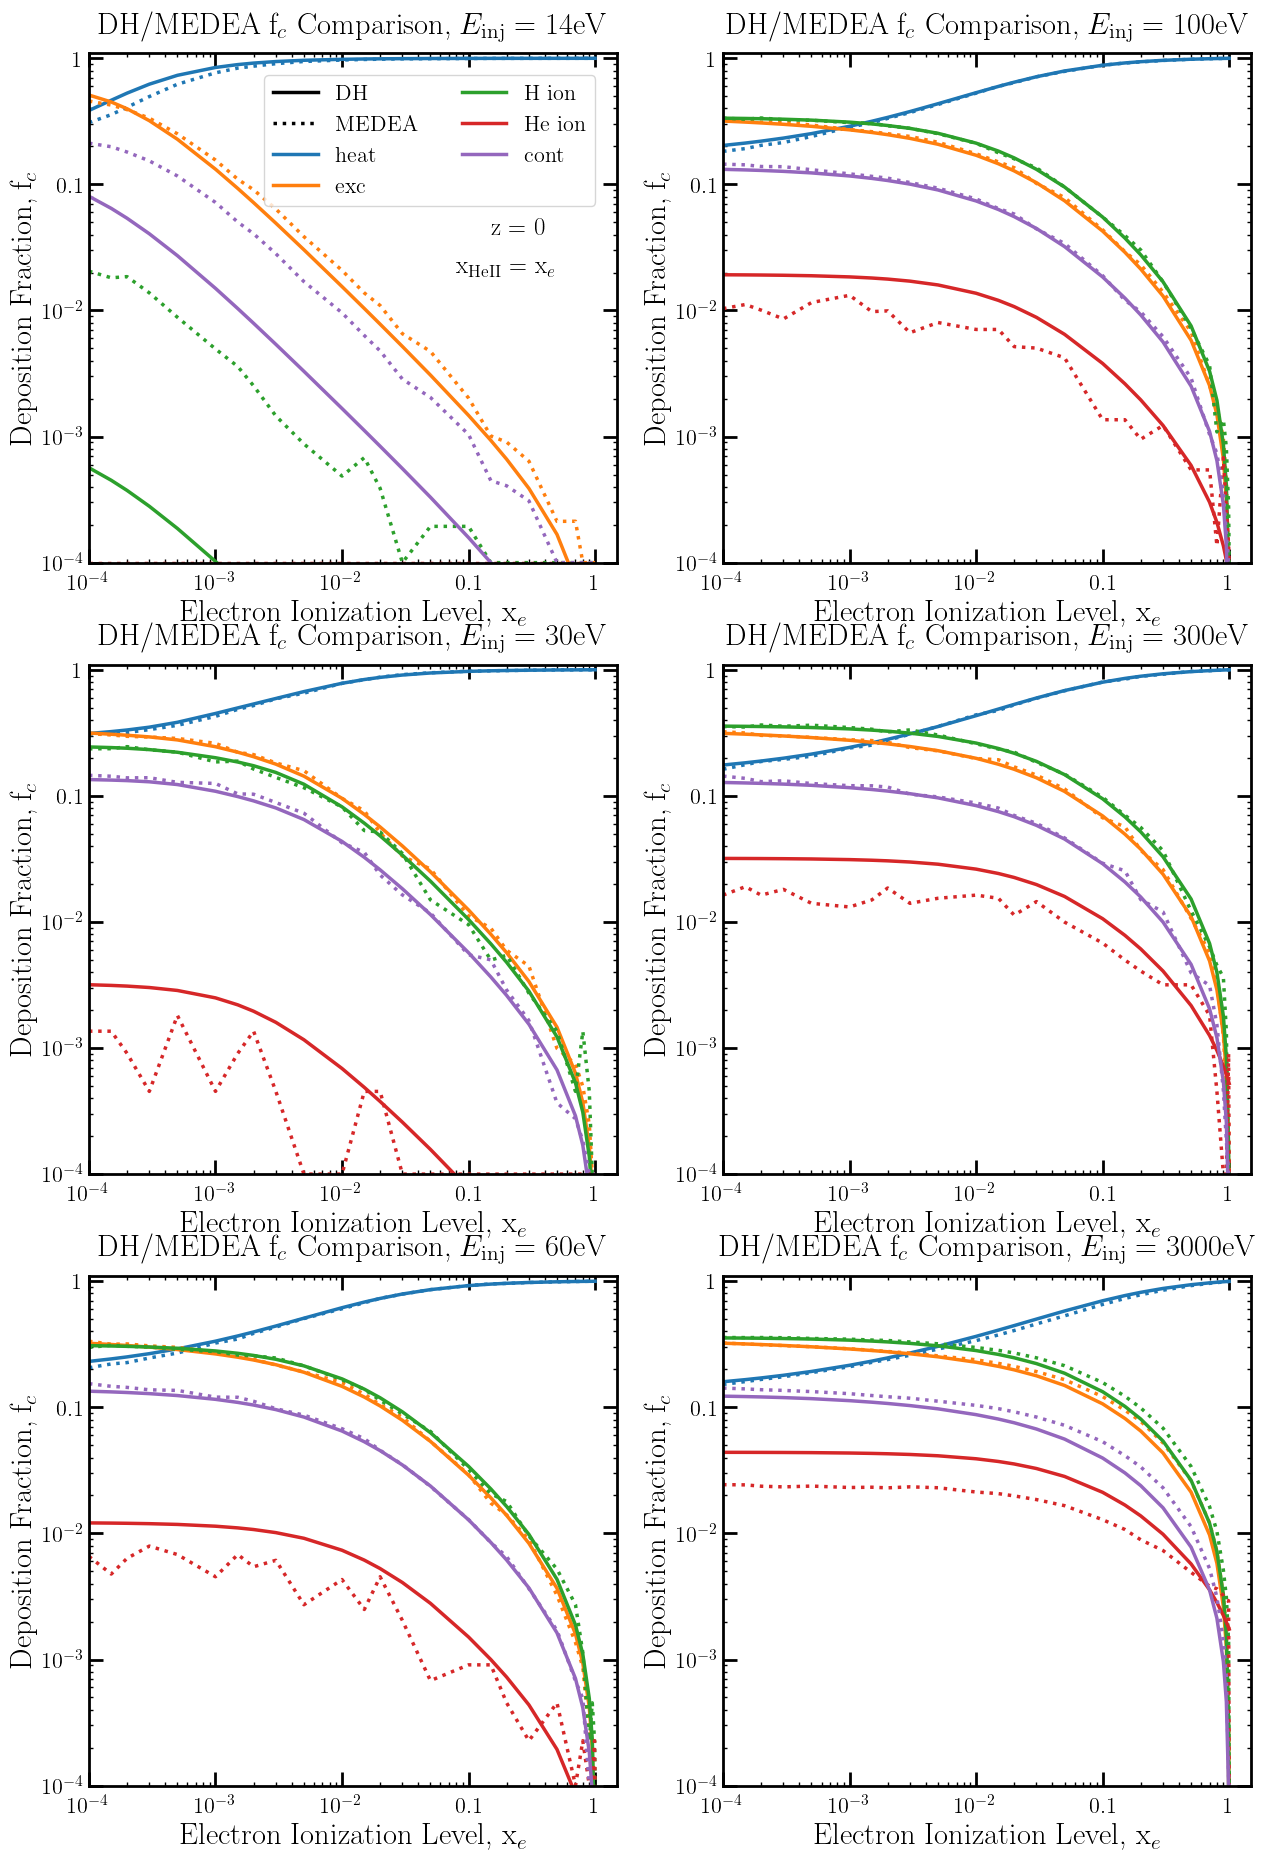

In [427]:
initEs = np.array([14, 30, 60, 100, 300, 3000])
n_fig_col = 3
fig, axarr = plt.subplots(3, int(initEs.size/n_fig_col),
                          figsize=(7.5*initEs.size/n_fig_col, n_fig_col*7.5))
for i, initE in enumerate(initEs):
    j = int(i%n_fig_col)
    k = int(np.floor(i/n_fig_col))
    DH_data = DH_interp.get_vals(xes,initE)
    MEDEA_data = MEDEA_interp.get_vals(xes,initE)

    axarr[j][k].loglog()
    axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', label='DH')
    axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', linestyle=':', label='MEDEA')

    for j1 in np.arange(5):
        axarr[j][k].plot(xes, DH_data[:,j1], color='C'+str(j1), label=channels[j1])
        axarr[j][k].plot(xes, MEDEA_data[:,j1], color='C'+str(j1), linestyle=':')

    axarr[j][k].axis([1e-4, 1.5, 1e-4,1.1])
    axarr[j][k].set_title(r'DH/MEDEA f$_c$ Comparison, $E_{\mathrm{inj}} = '+str(initE)+'$eV', fontsize=22)
    axarr[j][k].set_xlabel(r'Electron Ionization Level, x$_e$', fontsize=22)
    axarr[j][k].set_ylabel(r'Deposition Fraction, f$_c$', fontsize=22)
    if i!=1:
        leg_y = 4e-3
    else:
        leg_y = 7e-3
        
    if i == 0:
        leg_y = 0.04
        axarr[j][k].text(1.5e-1, leg_y, r'z = '+str(rs-1), fontsize = 18)
        axarr[j][k].text(8e-2, leg_y/2, r'x$_{\mathrm{HeII}}$ = x$_e$', fontsize = 18)
        axarr[j][k].legend(ncol=2)
    
plt.savefig(fig_dir+'MEDEA_CrossCheck.pdf')

# 3. $f_c(z)$ vs. Acharya+Khatri

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [354]:
files = ['heat', 'ICS', 'He ion', 'H ion', 'H exc2', 'H exc3', 'He exc']
Acharya_f = {'04': {}, '0002': {}}
for num in ['04', '0002']:
    for f in files:
        Acharya_f[num][f] = []
        with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/Distortions/'
                  +'Acharya'+num+'/'+f+'.csv') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                Acharya_f[num][f].append([float(row[0]),float(row[1])])
        Acharya_f[num][f] = np.array(Acharya_f[num][f])
        Acharya_f[num][f] = interp1d(Acharya_f[num][f][:,0], Acharya_f[num][f][:,1],
                                    bounds_error=False, fill_value=(1e-10,1e-10))

In [361]:
eleceng, photeng = binning['elec'], binning['phot']
H_states  = ['2s', '2p', '3p']

(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs, ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

simple_ICS = True
DH_f = {'04': {}, '0002': {}}
for i, num in enumerate(['04', '0002']):
    if num == '04':
        xHII = 4e-2
        rs = 1001
    else:
        xHII = 2e-4
        rs=101
        
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )
    
    DH_f[num]['heat'] = deposited_heat_arr/eleceng
#     if simple_ICS:
    DH_f[num]['ICS'] = deposited_ICS_arr/eleceng #(np.dot(ics_sec_phot_tf.grid_vals, photeng)-0*deposited_ICS_arr)/eleceng
#     else:
#         DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
#     DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
    DH_f[num]['He ion'] = deposited_ion_arr['He']/eleceng
    DH_f[num]['H ion']  = deposited_ion_arr['H']/eleceng
    DH_f[num]['H exc2'] = (deposited_exc_arr['2s']+deposited_exc_arr['2p'])/eleceng
    DH_f[num]['H exc3'] = deposited_exc_arr['3p']/eleceng
    DH_f[num]['He exc'] = (deposited_exc_arr['HeI']+deposited_exc_arr['HeII'])/eleceng

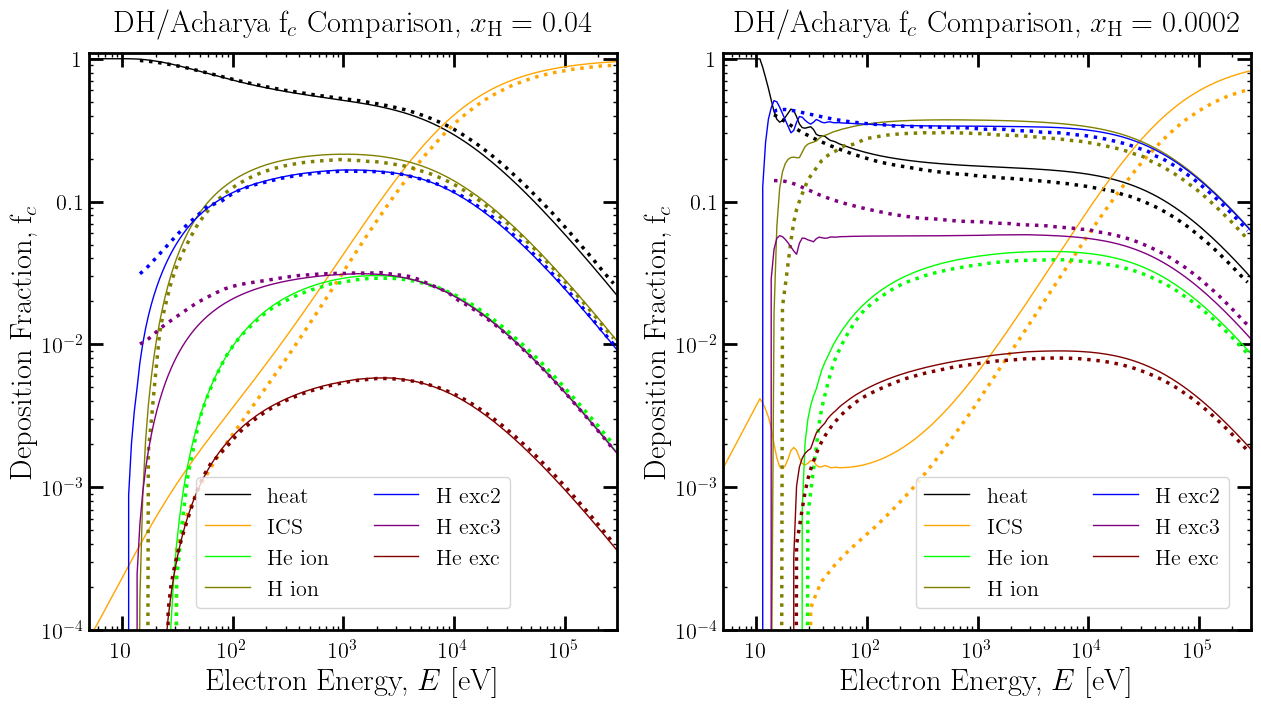

In [376]:
#!!! Remember how oscillations are related to excitation thresholds
#!!! Remember why ICS shoots up at 10eV in left plot
initEs = np.array([14, 30, 60, 100, 300, 3000])
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))
colors = {'heat':'k', 
              'ICS': 'orange', 
              'He ion': 'lime', 
              'H ion': 'olive', 
              'H exc2': 'blue', 
              'H exc3': 'purple', 
              'He exc': 'maroon'}
for i, num in enumerate(['04', '0002']):
    axarr[i].loglog()
    for f in files:
        ind1 = sum(eleceng<14)
        ind2 = sum(eleceng<2.93e5)
        axarr[i].plot(eleceng[ind1:ind2], Acharya_f[num][f](eleceng[ind1:ind2]),
                      color=colors[f], linestyle=':')
        axarr[i].plot(eleceng, DH_f[num][f], 
                      color=colors[f], linestyle='solid', linewidth=1, label=f)

    axarr[i].axis([5, 3e5, 1e-4,1.1])
    axarr[i].set_title(r'DH/Acharya f$_c$ Comparison, $x_{\mathrm{H}} = 0.$'+str(num), fontsize=22)
    axarr[i].set_xlabel(r'Electron Energy, $E$ [eV]', fontsize=22)
    axarr[i].set_ylabel(r'Deposition Fraction, f$_c$', fontsize=22)
    axarr[i].legend(ncol=2)
    
# plt.savefig(fig_dir+'AcharyaKhatri_CrossCheck.pdf')

# 4. $x_e(z)$ vs. Hyrec

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

In [25]:
# Download Hyrec plots
input_dir = '/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/'
EMLA_data = download_plot('EMLA', input_dir)
Rec_data = download_plot('Recfast', input_dir)

In [274]:
%autoreload
start_rs, end_rs = 3e3, 200

cf = 16  # coarsen_factor
dlnz = -.001 * cf
rs_vec = np.exp(np.arange(np.log(start_rs), np.log(end_rs), dlnz))

baseline = tla.get_history(rs_vec, fudge=1.0)
fudge_1_14 = tla.get_history(rs_vec, fudge=1.14)

NameError: name 'rs_vec' is not defined

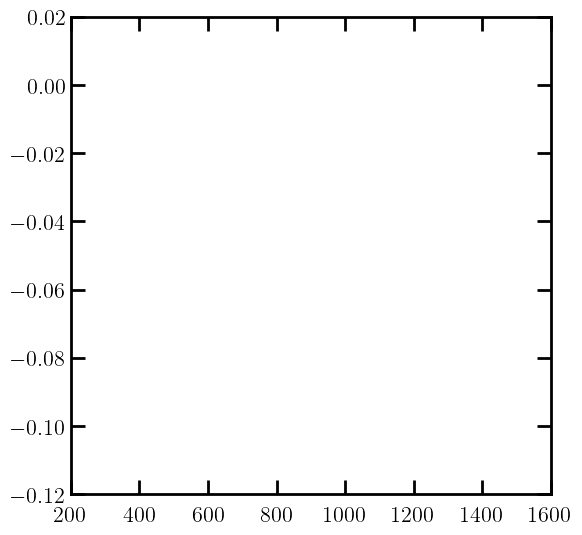

In [26]:
%autoreload
plt.figure()
plt.axis([200,1600, -.12,.02])

# DarkHistory plots
nmax=100
plt.plot(rs_vec, fudge_1_14[:,1]/baseline[:,1]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

plt.plot(rs_vec, iterated[:,1]/baseline[:,1]-1, 
         color='C2', linestyle='--', linewidth = 1.4, 
         label=r'DH: iterative')

goods = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                         'baseline_elec_decay_nmax100_endrs200_cf1_rtol6.dat', 'rb'))[1][5]
#                          'baseline_elec_decay_nmax100_endrs5.dat', 'rb'))[1][5]
#                          'full_run_endrs5.p', 'rb'))

res0 = tla.get_history(goods['rs'], fudge=1.0, rtol=1e-6)[:,1]
plt.plot(goods['rs'], goods['x'][:,0]/res0-1, 
         color='C4', linestyle='solid', linewidth = 2.0, 
         label=r'DH: Full')


# hyrec plots
lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')


# plot labels
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax), fontsize=12)

savefig=False
if savefig:
    plt.savefig(fig_dir+'xe_crosscheck.pdf')

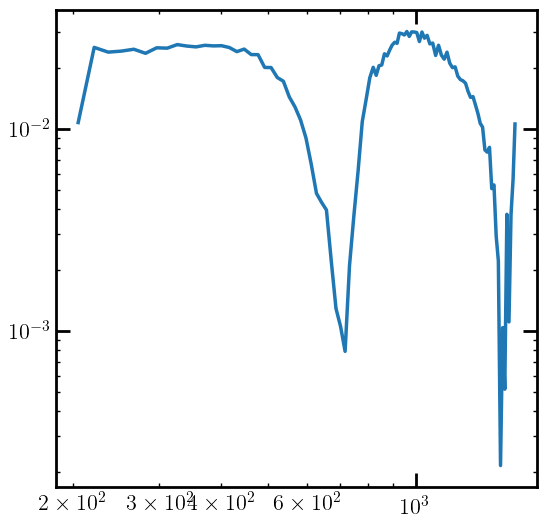

In [272]:
plt.figure()
plt.loglog()
y_func = interp1d(yacine_xe[:,0], yacine_xe[:,1], fill_value='extrapolate')
plt.plot(yacine_xe[:,0], np.abs(phys.xHII_std(yacine_xe[:,0])/10**y_func(yacine_xe[:,0])-1))
# plt.plot(yacine_xe[:,0], phys.xHII_std(yacine_xe[:,0]))

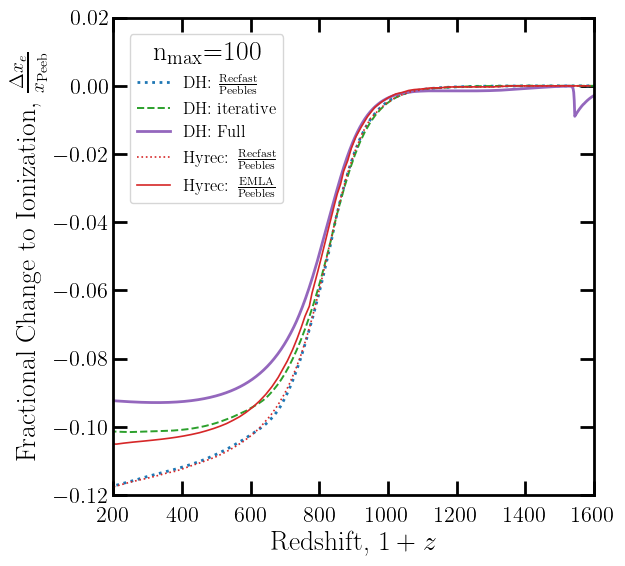

In [297]:
%autoreload
plt.figure()
plt.axis([200,1600, -.12,.02])

# DarkHistory plots
nmax=100
plt.plot(rs_vec, fudge_1_14[:,1]/baseline[:,1]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

plt.plot(rs_vec, iterated[:,1]/baseline[:,1]-1, 
         color='C2', linestyle='--', linewidth = 1.4, 
         label=r'DH: iterative')

# plt.plot(rs_vec, 10**y_func(rs_vec)/baseline[:,1]-1, 
#          color='C2', linestyle='--', linewidth = 1.4, 
#          label=r'DH: iterative')

goods = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                         'baseline_elec_decay_nmax100_endrs200_cf1_rtol6.dat', 'rb'))[1][5]
#                          'baseline_elec_decay_nmax100_endrs5.dat', 'rb'))[1][5]
#                          'full_run_endrs5.p', 'rb'))

res0 = tla.get_history(goods['rs'], fudge=1.0, rtol=1e-6)[:,1]
plt.plot(goods['rs'], goods['x'][:,0]/res0-1, 
         color='C4', linestyle='solid', linewidth = 2.0, 
         label=r'DH: Full')


# hyrec plots
lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')


# plot labels
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax), fontsize=12)

savefig=False
if savefig:
    plt.savefig(fig_dir+'xe_crosscheck.pdf')

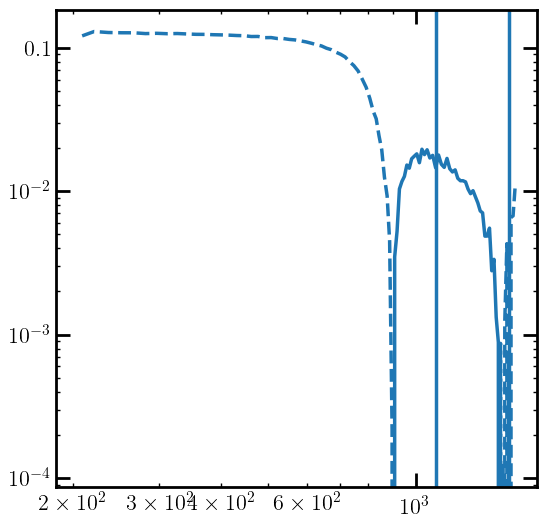

In [304]:
plt.figure()
plt.loglog()
rs_tmp = np.flipud(yacine_xe[:,0])
res0 = tla.get_history(rs_tmp, fudge=1.0, rtol=1e-6)[:,1]
plt.plot(rs_tmp, 10**y_func(rs_tmp)/res0-1)
plt.plot(rs_tmp, 1-10**y_func(rs_tmp)/res0, linestyle='--', color='C0')

plt.axvline(1.1e3)
plt.axvline(1.55e3)

In [299]:
input_dir = '/Users/gregoryridgway/Desktop/Webplot Digitizer/Yacine_xe/'
yacine_xe = download_plot('Yacine_xe', input_dir)
# yacine_diffs = {i : download_plot(str(i), input_dir) for i in [64, 128, 250, 500]}

# 5. `distortion` vs. Jens+Sunyaev

Short Description of the cross-check, hrefs to the relevant papers, pointers to the relevant plots

- BB only, nmax = 10,20,30, no 2s
- BB only, with 2s
- BB + BF + 2s

In [100]:
# Dictionary containing different types of distortions
distortion_dict = {}

# Create 2s -> 1s spectrum
hplanck = phys.hbar * 2*np.pi
eng = np.exp(np.linspace(
    np.log(hplanck*1e8), np.log(phys.rydberg), 500))

spec_2s1s = spectools.discretize(eng, phys.dNdE_2s1s)

In [239]:
%autoreload
rs_vec = np.exp(np.arange(np.log(3.5e3), np.log(5e2), dlnz))

# Load old runs
load = False

if load:
    distortion_dict['100_2sBF'] = pickle.load(open(
        '/Users/gregoryridgway/Dropbox (MIT)/'+
        'DarkHistory_V2/data/distortion100.p','rb'))  # includes 2s and BF
    
else:

    for nmax in [10,20,30,100][1:2]:

        if nmax==100:
            include_2s1s, include_BF = True, True
        else:
            include_2s1s, include_BF = False, False


        key = str(nmax)
        if include_2s1s:
            key += '_2s'
        if include_BF:
            key += 'BF'

        if key not in distortion_dict:
            distortion_dict[key] = Spectrum(
                eng, np.zeros_like(eng), spec_type='N', rs=1)
        else:
            distortion_dict[key].N *= 0

        # Store individual components of the distortion
        delta_dists = Spectra(
            np.zeros((len(rs_vec), len(eng))), 
            eng=eng, spec_type='N', rs=rs_vec)
        
        R = atomic.populate_radial(nmax)

        # Build up the distortion one redshift at a time
        for i, rs in enumerate(tqdm(rs_vec)):

            dt = -dlnz/phys.hubble(rs)
            xHI = phys.xHI_std(rs)
            Tm = phys.Tm_std(rs)

            _, transition_spec = atomic.process_MLA(
                rs, dt, xHI, Tm, nmax, spec_2s1s.eng, R,
                Delta_f=None, cross_check=False,
                include_2s1s=include_2s1s, include_BF=include_BF, spec_2s1s=spec_2s1s
            )

            delta_dists._grid_vals[i] = transition_spec.N
            transition_spec.redshift(1)
            distortion_dict[key] += transition_spec.N

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_96093/3970037046.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_vec)):


  0%|          | 0/122 [00:00<?, ?it/s]

In [22]:
def download_plot(file, input_dir='/Users/gregoryridgway/Desktop/Webplot_distortion/'):
    with open(input_dir+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')

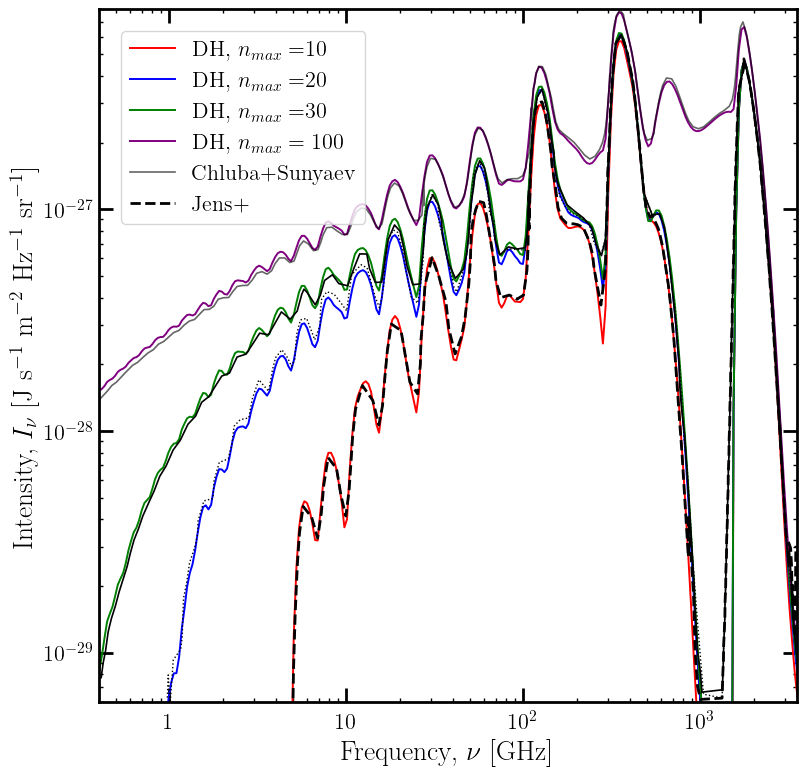

In [241]:
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(9, 9))
plt.loglog()
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])

# DH generated data
ns = ['10','20','30', '100_2sBF']
colors = ['red', 'blue', 'green', 'purple']
labels = ['DH, $n_{max}=$'+nmax if nmax != '100_2sBF' else 'DH, $n_{max}=100$' for nmax in ns]

for i,nmax in enumerate(ns):
    plt.plot(nu/1e9, convert * distortion_dict[nmax].dNdE,
             color=colors[i], linewidth=1.4, label=labels[i])
# plt.plot(nu/1e9, convert * goods['distortion'].dNdE)

# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
plt.plot(n10_data[:,0], n10_data[:,1], color='k',
         linewidth=2.0, linestyle='--', label='Jens+')
plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

plt.legend(loc=2)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
if cf>1 and (not load):
    print('WARNING: There are extra errors from coarsening')
    
    
plt.savefig(fig_dir+'baseline_distortion.pdf')

# $n_{max}$ convergence

In [70]:
import darkhistory.low_energy.bound_free as bf
hplanck = phys.hbar * 2*np.pi

nmax_convergence_alt = {}

# rs_list = np.exp(np.arange(np.log(3e3), np.log(200), -.001*16))
rs_list = np.exp(np.arange(np.log(3e3), np.log(200), -.001))

baseline = tla.get_history(rs_list, high_rs=1.555e3,
                           fudge=1.0, gauss_fudge=False, rtol=1e-8)
fudge_1_14 = tla.get_history(rs_list, high_rs=1.555e3,
                             fudge=1.14, gauss_fudge=False, rtol=1e-8)

dist_eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 10))
spec_2s1s = spectools.discretize(dist_eng, phys.dNdE_2s1s)

In [131]:
# MLA_funcs200 = MLA_funcs.copy()
# MLA_funcs300 = MLA_funcs.copy()

In [76]:
%autoreload

for nmax in [100,200]:
    R = atomic.populate_radial(nmax)
    Thetas = bf.populate_thetas(nmax)

    MLA_data = np.zeros((rs_list.size, 3))
    for i, rs in enumerate(tqdm(rs_list)):

        MLA_data[i], _ = atomic.process_MLA(
            rs, 1, phys.x_std(rs, 'HI'), 
            phys.Tm_std(rs), nmax, dist_eng, R, Thetas,
            spec_2s1s=spec_2s1s, delta_b={}
        )

    MLA_funcs = [interp1d(rs_list, MLA_data[:,i], fill_value='extrapolate')
                 for i in range(3)]

    nmax_convergence_alt[nmax] = tla.get_history(
        rs_list, high_rs=1.555e3,
        recfast_TLA=False, MLA_funcs=MLA_funcs,
        rtol=1e-8
    )

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_80363/2416271206.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_list)):


  0%|          | 0/2709 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


  0%|          | 0/2709 [00:00<?, ?it/s]

In [153]:
nmax=50
rs_list = np.exp(np.arange(np.log(3e3), np.log(1), -.001*16))

In [154]:
R = atomic.populate_radial(nmax)
Thetas = bf.populate_thetas(nmax)

MLA_data = np.zeros((rs_list.size, 3))
for i, rs in enumerate(tqdm(rs_list)):

    MLA_data[i], _ = atomic.process_MLA(
        rs, 1, phys.xHI_std(rs), 
        phys.Tm_std(rs), nmax, dist_eng, R, Thetas,
        spec_2s1s=spec_2s1s, delta_b={}
    )

MLA_funcs = [interp1d(rs_list, MLA_data[:,i], fill_value='extrapolate')
             for i in range(3)]

tmp3 = tla.get_history(
    rs_list, high_rs=1.555e3,
    recfast_TLA=False, MLA_funcs=MLA_funcs,
    rtol=1e-8
)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_80363/355805581.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_list)):


  0%|          | 0/501 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:594: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:598: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHist

In [137]:
baseline_tmp = tla.get_history(
    rs_list, rtol=1e-8, gauss_fudge=False, fudge=1.0, high_rs=1.555e3)

Text(0, 0.5, 'Fractional Change to Ionization, $\\frac{\\Delta x_e}{x_{\\mathrm{Peeb}}}$')

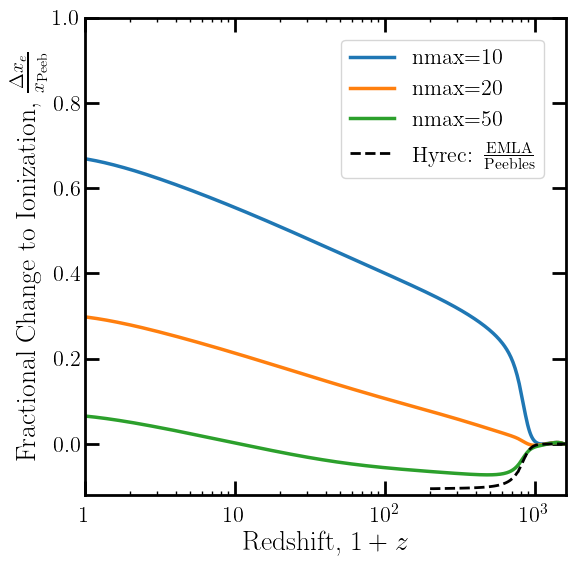

In [160]:
plt.figure()
plt.axis([1,1600, -.12,1.0])
ax = plt.gca()
ax.set_xscale('log')
# ax.loglog()
ax.plot(rs_list, tmp[:,1]/baseline_tmp[:,1]-1, label='nmax=10')
ax.plot(rs_list, tmp2[:,1]/baseline_tmp[:,1]-1, label='nmax=20')
ax.plot(rs_list, tmp3[:,1]/baseline_tmp[:,1]-1, label='nmax=50')

ax.plot(EMLA_data[:,0], EMLA_data[:,1], color='black', 
         linewidth = 2.0, linestyle = '--', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.legend()
ax.set_xlabel(r'Redshift, $1+z$', fontsize=20)
ax.set_ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)

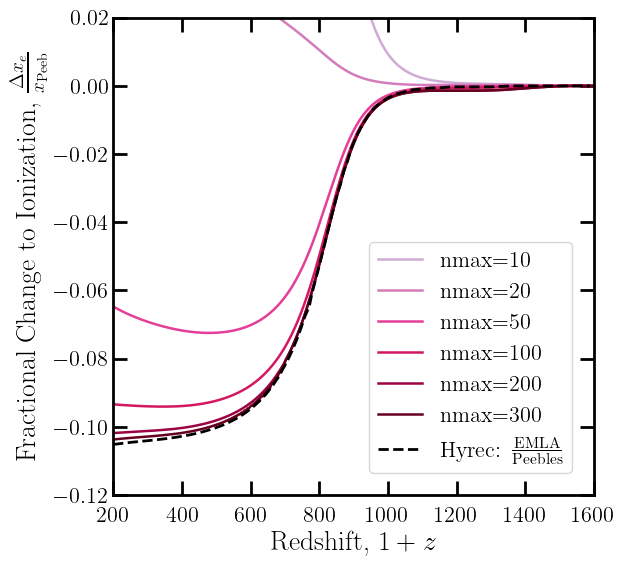

In [133]:
%autoreload
plt.figure()
plt.axis([200,1600, -.12,.02])
ax = plt.gca()
# cm = plt.get_cmap('inferno')

# DarkHistory plots
# plt.plot(rs_list, fudge_1_14[:,1]/baseline[:,1]-1, 
#          color='C0', linestyle=':', linewidth = 2.0, 
#          label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

color = iter(plt.cm.PuRd(np.linspace(0.3, 1, len([10, 20, 50, 100, 200, 300]))))

for i,nmax in enumerate([10, 20, 50, 100, 200, 300]):
    c = next(color)
    ax.plot(rs_list, nmax_convergence_alt[nmax][:,1]/baseline[:,1]-1, 
             linewidth = 1.8, 
             label=r'nmax='+str(nmax), c=c)
    
# plt.plot(rs_tmp, tmp[:,1]/baseline_tmp[:,1]-1, 
#          linewidth = 1.4, 
#          label=r'nmax='+str(nmax))


# hyrec plots
lw = 1.2
# plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
#          linewidth = lw, linestyle = ':', 
#          label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
ax.plot(EMLA_data[:,0], EMLA_data[:,1], color='black', 
         linewidth = 2.0, linestyle = '--', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')


# plot labels
ax.set_xlabel(r'Redshift, $1+z$', fontsize=20)
ax.set_ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
ax.legend()#title=r'$\mathrm{n_{max}}$='+str(nmax), fontsize=12)
# plt.title('No Coarsening')

plt.savefig(fig_dir+'xe_crosscheck.pdf')

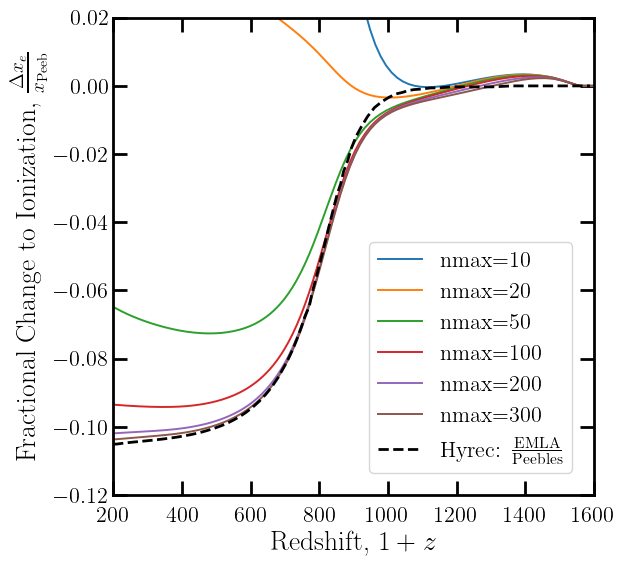

In [68]:
%autoreload
plt.figure()
plt.axis([200,1600, -.12,.02])

# DarkHistory plots
# plt.plot(rs_list, fudge_1_14[:,1]/baseline[:,1]-1, 
#          color='C0', linestyle=':', linewidth = 2.0, 
#          label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

for nmax in [10, 20, 50, 100, 200, 300]:
    plt.plot(rs_list, nmax_convergence[nmax][:,1]/baseline[:,1]-1, 
             linewidth = 1.4, 
             label=r'nmax='+str(nmax))
    
# plt.plot(rs_tmp, tmp[:,1]/baseline_tmp[:,1]-1, 
#          linewidth = 1.4, 
#          label=r'nmax='+str(nmax))


# hyrec plots
lw = 1.2
# plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
#          linewidth = lw, linestyle = ':', 
#          label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='black', 
         linewidth = 2.0, linestyle = '--', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')


# plot labels
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
plt.legend()#title=r'$\mathrm{n_{max}}$='+str(nmax), fontsize=12)

savefig=False
if savefig:
    plt.savefig(fig_dir+'xe_crosscheck.pdf')

# 6. Misc

### Hirata_2005

In [ ]:
(
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            #loweng=eleceng[0], 
            spec_2s1s = spec_2s1s,
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )

In [ ]:
#Probs that a given state decays ultimately to '2p'
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

### Testing the TLA assumptions (getting back detailed balance, then Peebles C)

In [203]:
alphas, betas = {}, {}

In [227]:
%autoreload
rs_vec = np.exp(np.arange(np.log(1.555e3), np.log(5), -dlnz))
rs_vec = np.exp(np.linspace(np.log(3e3), np.log(5), 150))

nmax = 100
key = str(nmax)

# if key not in alphas:
alphas[key], betas[key] = np.zeros_like(rs_vec), np.zeros_like(rs_vec)

# Build up the distortion one redshift at a time
for i, rs in enumerate(tqdm(rs_vec)):

    dt = dlnz/phys.hubble(rs)
    xHI = phys.xHI_std(rs)
    Tm = phys.Tm_std(rs)

    alphas[key][i], betas[key][i], transition_spec = atomic.process_MLA(
        rs, dt, xHI, Tm, nmax, spec_2s1s,
        Delta_f=None, cross_check=False,
        include_2s1s=include_2s1s, include_BF=include_BF
    )

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_7059/1734762317.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, rs in enumerate(tqdm(rs_vec)):


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:493: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:497: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:523: RuntimeWarning: divide by zero encountered in double_scalars
  b[nl] /= tot_rate


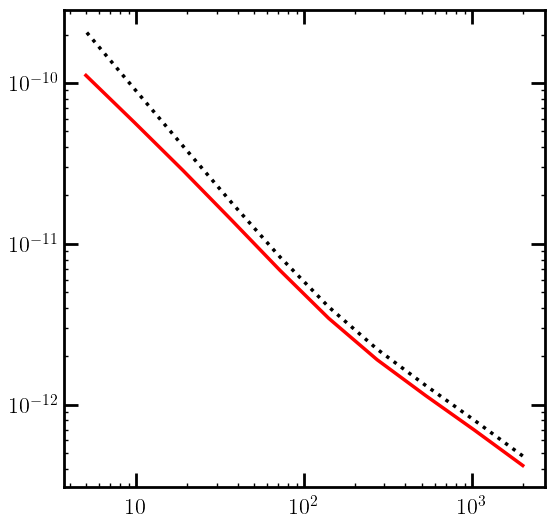

In [228]:
plt.figure()
plt.loglog()

plt.plot(rs_vec, alphas[key+'stim'], color='red')
# plt.plot(rs_vec, betas, color='red', linestyle=':')

plt.plot(rs_vec, phys.alpha_recomb(phys.Tm_std(rs_vec), 'HI'),
         color='k', linestyle=':')
# plt.plot(rs_vec, phys.beta_ion(phys.Tm_std(rs_vec), 'HI'), color='k', linestyle=':')

(1e-07, 0.01)

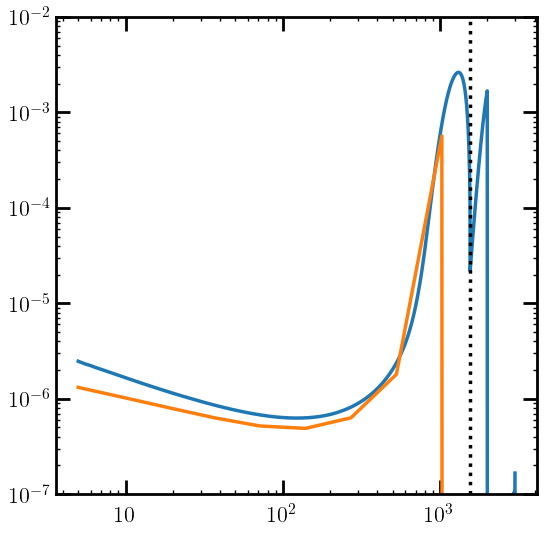

In [242]:
from scipy.interpolate import interp1d

plt.figure()
plt.loglog()

xHII_vec = phys.xHII_std(rs_vec)
xHI_vec = phys.xHI_std(rs_vec)
nH_vec = phys.nH*rs_vec**3
Tm_vec = phys.Tm_std(rs_vec)

# stuff = phys.alpha_recomb(
#     Tm_vec, 'HI') * xHII_vec**2 * nH_vec - \
#     4 * phys.beta_ion(Tm_vec, 'HI') * xHI_vec * np.exp(-phys.lya_eng/phys.TCMB(rs_vec))
    
# stuff *= -phys.peebles_C(xHII_vec, rs_vec)

# plt.plot(rs_vec, phys.dtdz(rs) * stuff)

rs_plot = np.exp(np.arange(np.log(3e3), np.log(5), -.001))
plt.plot(rs_plot, phys.xdot(phys.xHII_std(rs_plot), rs_plot))

stuff = alphas[key] * xHII_vec**2 * nH_vec - betas[key]
stuff *= -phys.dtdz(rs_vec)
# stuff = interp1d(rs_vec, stuff, 'linear')
# mask = rs_plot<rs_vec[0]
plt.plot(rs_vec, stuff)
plt.axvline(1.555e3, linestyle=':', color='k')

plt.ylim([1e-7,1e-2])

# plt.plot(rs_vec[:-1], np.diff(xHII_vec)/np.diff(rs_vec))

In [318]:
%autoreload

end_rs = 4.01
baseline_reion_no_heat = main.evolve(
    DM_process='decay', mDM=2e8,
    lifetime=2.2e45, primary='elec_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, 
    reion_switch=True, reion_method=None, reion_rs=30,
    heat_switch=True, DeltaT = 1*phys.kB, alpha_bk = 1e5,
    xe_reion_func = reion_interps['FlexKnot_early'],
    distort=True, recfast_TLA=True, nmax=nmax
)

  0%|          | 0/414.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:683: RuntimeWarning: overflow encountered in true_divide
  x_full[(states_l == l+1) * (


In [321]:
%autoreload
baseline_reion_heat = main.evolve(
    DM_process='decay', mDM=2e8,
    lifetime=2.2e45, primary='elec_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, 
    reion_switch=True, reion_method=None, reion_rs=30,
    heat_switch=True, DeltaT = 2e4*phys.kB, #alpha_bk = 1e5,
    xe_reion_func = reion_interps['FlexKnot_early'],
    distort=True, recfast_TLA=True, nmax=nmax
)

  0%|          | 0/414.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:683: RuntimeWarning: overflow encountered in true_divide
  x_full[(states_l == l+1) * (


Text(0.5, 0, 'Redshift, $1+z$')

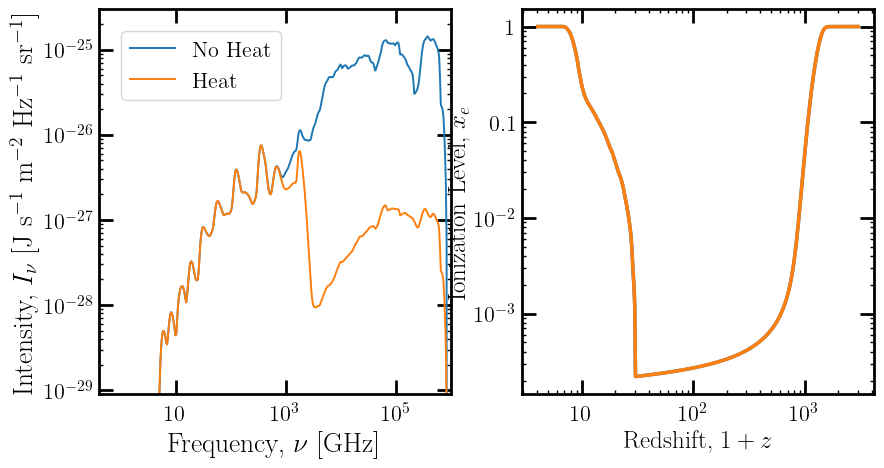

In [334]:
_, axarr = plt.subplots(1,2,figsize=(10,5))

plot_distortion(axarr[0], baseline_reion_no_heat, label='No Heat', leg=True, first=False)
plot_distortion(axarr[0], baseline_reion_heat, ylim=[9e-30, 3e-25], label='Heat', leg=True, first=False)

axarr[1].loglog()

axarr[1].plot(baseline_reion_no_heat['rs'], baseline_reion_no_heat['x'][:,0])
axarr[1].plot(baseline_reion_heat['rs'], baseline_reion_heat['x'][:,0])

# axarr[1].set_ylabel(r'Temperature, $T_m$ [K]')
axarr[1].set_ylabel(r'Ionization Level, $x_e$')
axarr[1].set_xlabel(r'Redshift, $1+z$')

Text(0.5, 0, 'Redshift, $1+z$')

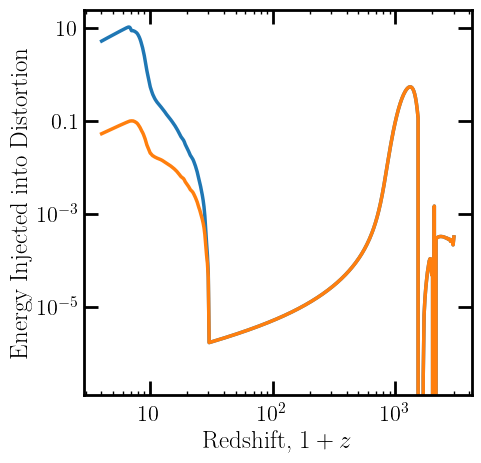

In [337]:
plt.figure(figsize=(5,5))
plt.loglog()

plt.plot(baseline_reion_no_heat['rs'], 
         baseline_reion_no_heat['distortions'].toteng())

plt.plot(baseline_reion_no_heat['rs'], 
         baseline_reion_heat['distortions'].toteng())

plt.ylabel('Energy Injected into Distortion')
plt.xlabel(r'Redshift, $1+z$')

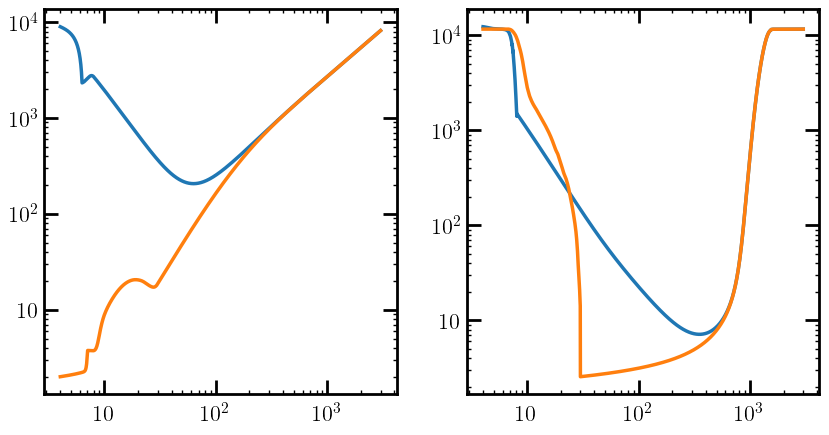

In [254]:
%autoreload
# reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
# bump_interp = make_reion_interp_func('Tanh_late', True)
tmp = tla.get_history(
    rs_tmp, rtol=1e-4,
    reion_switch=True, reion_rs=30, xe_reion_func = bump_interp,
    inj_particle='elec', DM_process='decay', mDM=2e8, lifetime=2.2e25,
    baseline_f = True
)

tmp2 = tla.get_history(
    rs_tmp, rtol=1e-4,
    reion_switch=True, reion_rs=30, xe_reion_func = reion_interps['FlexKnot_early'],
    heat_switch=True, DeltaT = 1*phys.kB, alpha_bk = 1e5
#     inj_particle='elec', DM_process='decay', mDM=2e8, lifetime=2.2e25,
#     baseline_f = True
)


_, axarr = plt.subplots(1,2, figsize=(10,5))

for i in range(2):
    axarr[i].loglog()
    axarr[i].plot(rs_tmp, tmp[:,i]/phys.kB)
    axarr[i].plot(rs_tmp, tmp2[:,i]/phys.kB)

In [407]:
4 * np.pi**2 / 45 * phys.TCMB(1)**3 / (phys.hbar*phys.c)**3

1479.2618256482506

In [409]:
phys.s0/2

1445.6

Text(0, 0.5, 'Strong Coupling Constant, $\\alpha_s$')

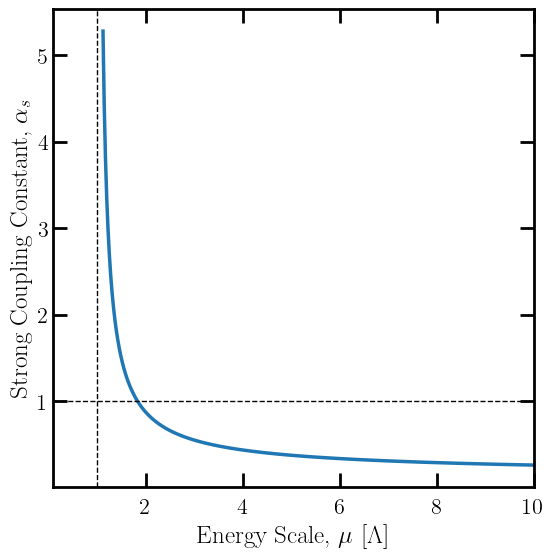

In [193]:
mu = np.logspace(.05, 1, 100)

plt.figure()
plt.plot(mu, 12*np.pi/(11*3-2*1)/np.log(mu**2))

plt.xlim([.1,10])

plt.axvline(1.0, color='k', linestyle='--', linewidth=1.0)
plt.axhline(1.0, color='k', linestyle='--', linewidth=1.0)
plt.xlabel(r'Energy Scale, $\mu$ [$\Lambda$]')
plt.ylabel(r'Strong Coupling Constant, $\alpha_s$')